# Clustering and Gradient Boosting DHS Data to Address DV in India
***

With 1.2 billion people, India is the most populous democracy and the fastest growing economy in the world ([Economist](https://www.economist.com/graphic-detail/2018/01/05/the-fastest-growing-and-shrinking-economies-in-2018).) With 624 million males and 586 million females, it hosts one of the worlds largest systems of gender-based violence. If a woman makes it past the sieves of sex-selective abortion, infanticide, and infant abandonment, there is a 30% chance she will experience domestic violence (“dv”.) Even though domestic violence has been a criminal offense since 1983, and “civil protections [have been] afforded to victims of domestic violence” since 2006, only 14% of women who have experienced domestic violence seek help, only 3% seek help from the police, and only 1% seek help “from a doctor or medical personnel, a lawyer, or a social service organization” ([NFHS-4](https://www.dhsprogram.com/pubs/pdf/FR339/FR339.pdf).)

There is a significant amount of socio-cultural work to be done. Men need to learn to value women, to protect them rather than mistreat them. Abusers need to be made aware that there are potentially legal consequences for their actions. In 2014, the World Bank “found that 38 percent of people surveyed [in India] were not aware of laws on violence against women….Men who were unaware of the law were 1.5 times more likely to perpetrate intimate partner violence” ([World Bank](http://pubdocs.worldbank.org/en/232551485539744935/WDR17-BP-Gender-based-violence-and-the-law.pdf).) Additionally, women need to learn that they are valuable, do not deserve to be mistreated, and when possible, to access the resources available. 

This analysis uses K-Means Clustering to group women by experience with domestic violence to determine the best medium for reaching each group and Gradient Boosting Classification to uncover driving factors to inform message design. This analysis found that there were three main groups of women: those who were abused, those who did not report abuse but were afraid of their husbands, and those that did not report abuse or fear their partners. While demographic features like wealth and education were correlated with gradient boosting revealed behavioral factors like partner's drinking and controlling behaviors to be drivers of domestic violence.

The data are from USAID’s Demographic and Health Surveys, India: Standard DHS, 2015-16. The survey has 79,729 respondents for the domestic violence module and also covers many aspects of health and demographics. This analysis focuses on women currently in a union, of which there are 62,716 respondents in the original data set. There are over 4,000 columns in the original dataset.

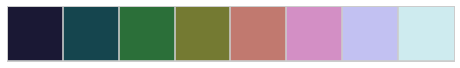

In [1]:
# Imports
%matplotlib inline
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
import catboost as cb

import xgboost as xgb
from xgboost import plot_importance

# Setup pandas
pd.options.display.max_rows = 400
pd.options.display.max_columns = None

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")
palette = sns.color_palette("cubehelix", 8)
sns.set_palette(palette)
sns.palplot(palette)


In [2]:
# Creating df from csv of women who were interviewed

#Record start time of processing
start = datetime.datetime.now()

# Loading data into df
csv = 'interviewed_women.csv'
dfi = pd.read_csv(csv, low_memory=False)

#Record end time of processing
end = datetime.datetime.now()
print("Duration:", end - start)

Duration: 0:01:27.524334


In [3]:
# V044 Selection for Domestic Violence Module (Only women interviewed for dv module were kept.)
print("Who is in sample?:", dfi.v044.unique())

# Were all women interviewed, or just women who had ever been married?
print("Which women were surveyed?:", dfi.v020.unique())

dfi.shape

Who is in sample?: ['woman selected and interviewed']
Which women were surveyed?: ['all woman sample']


(79729, 4797)

In [4]:
# Create df with only columns of interest from dfi
# Include rows for women currently in a union only

# Read data dictionary csv to df, which contains information like column definitions and intended uses
data_dict = pd.read_csv('data_dict.csv')

# Get list of columns of interest from data_dict
cols_of_interest = list(data_dict['variable'][data_dict['use'].notnull()])

# List of columns of interest in dfi
interesting_in_dfi = [item for item in cols_of_interest if item in dfi]

df = dfi[interesting_in_dfi]
df = df.loc[df['v502'] == 'currently in union/living with a man',:]
print("Shape of df:", df.shape)

# Get list of interesting columns that are not in df
not_in_df = [item for item in cols_of_interest if item not in df]
print("Interesting columns not in df:", not_in_df)

Shape of df: (62716, 78)
Interesting columns not in df: []


## Cleaning the Data
***
Here is an [article](https://www.edupristine.com/blog/k-means-algorithm) I found helpful for k-means pre-processing.

In [5]:
# Dictionary for renaming columns for easier interpretation
col_name_dict = {'d106':'dv_phys_less'
                 ,'d107':'dv_phys_more'
                 ,'d102' :'control_issues'
                 ,'d124':'v_sex_ttm'
                 ,'d128':'told_ever'
                 ,'d129':'afraid'
                 ,'d117a':"v_phys_tt2m"
                 ,'d119y':"no_one_stop"
                 ,'v153': "hh_phone"
                 ,'v012':"age"
                 ,'d111':"any_result_husband_action"
                 ,'d121':"v_between_parents"
                 ,'d115y':"v_phys_ever"
                 ,'hh_health': "health_dec"
                 ,'v731': "worked_ttm"
                 ,'reasons_thresh':"justs"
                 ,'v730': "age_partner"
                 ,'v715': "education_partner"
                 ,'v133':"education"
                 ,'v745a':"owns_house"
                 ,'v745b':"owns_land"
                 ,'v714':"working"
                 ,'v504':"partner_in_hh"
                 ,'v746':"earns_more"
                 ,'v505':"in_poly_union"
                }

# Adding these values to data_dict
data_dict['short_description'] = data_dict['variable'].replace(col_name_dict)

### "Yes" and "No" Values

In [6]:
# Replace yes/no with 1/0. 
df = df.replace('no', 0)
df = df.replace('yes', 1)

### Null Values

In [7]:
# Find list of columns in df that are completely null
all_null = df.columns[df.isnull().all()]

# Remove columns where all values are null
df = df.dropna(axis = 1, how = 'all')

# Print data_dict for variables that were all null (or the resulting shape of df)
#data_dict[data_dict.variable.isin(all_null)]
df.shape

(62716, 66)

After reading through the documentation, it makes sense that these columns would be all null. They were either removed from the survey, or were never included in the Indian version of the DHS survey in the first place.

In [8]:
# Identify columns that contain some nulls and decide how to remove/replace null values 

def display_count(var = list(df.columns.unique())):
    
    """
    Shows relevant parts of data_dict.

    """
    
    # Need to identify which columns are object types
    objs = list(df.select_dtypes(include=['object']).dtypes.to_frame().index)
    data_dict['objs'] = np.where(data_dict.variable.isin(objs), 1, 0)
    
    # Create df that shows columns names with count of null values 
    null_count = df.isna().sum().sort_values(ascending = False)
    null_count = null_count.to_frame().rename(columns={0: "nulls"})
    #null_count = null_count[null_count.num_nulls > 0]
    
    # Add in the column descriptions by merging with data_dict
    null_count = pd.merge(null_count, data_dict, left_index=True, right_on = 'variable')
    null_count[['variable','nulls','description','type']]

    # Create df of variable name and unique values of each variable in df
    objects = list(null_count.variable.unique())
    d = []
    for object in objects:
        d.append({'variable': object, 'unique_values': df[object].unique(),'dtype': df[object].dtype})
    df_uniq = pd.DataFrame(d)
    
    # Merge null_count with df_uniq
    null_count = pd.merge(null_count, df_uniq)

    if var == 'nulls':
        null_count = null_count[['variable',var,'type','dependent','description','unique_values']]
        #display(null_count[(null_count[var] > 0) & (null_count['type']=='segment')]) # Only need to remove nulls for segmentation variables
        display(null_count[null_count[var] > 0])
    elif var == 'objs':
        null_count = null_count[['variable',var,'type','dependent','description','unique_values']]
        #display(null_count[(null_count[var] > 0) & (null_count['type']=='segment')]) # Only need to transform objs for segmentation
        display(null_count[null_count[var] > 0])
    else: 
        null_count = null_count[['variable','type','dependent','description','unique_values','dtype','final_use','short_description']]
        display(null_count[null_count['variable'].isin(var)])

In [9]:
display_count('nulls')

,variable,nulls,type,dependent,description,unique_values
0,d124,62133,segment,NaN,D124 Anyone other than partner forced responde...,"[nan, 0, refused to answer/no response, 1]"
1,d117a,58149,profile,v502,D117A Times hit by other than partner last 12 ...,"[nan, sometimes, not at all, often]"
2,v746,47739,segment,"v502, v731, v741",V746 Whether the respondent earns more than he...,"[nan, less than him, more than him, about the ..."
3,d128,44872,profile,NaN,D128 Have ever told anyone else about violence.,"[nan, 0.0, 1.0]"
4,d114,43292,segment,"v502, d113",D114 Times partner gets drunk.,"[nan, sometimes, often, never]"
5,v741,43002,segment,v731,V741 Type of earnings for work. The respondent...,"[nan, cash only, cash and in-kind, not paid, i..."
6,v743f,464,segment,v502,V743F What to do with money husband earns - Fi...,"[husband/partner alone, respondent and husband..."
7,v131,246,segment,NaN,V131 Ethnicity. Both the question and the code...,"[no caste/tribe, caste, tribe, nan, don't know]"


In [10]:
# Fill in zeros for columns that are dependent on other columns (Most important that segmentation variable have no nulls)

# List of columns dependent on v731
data_dict['dep_v731'] = data_dict['dependent'].str.contains('v731').fillna(False)
dep_v731 = data_dict['variable'][data_dict['dep_v731']== True]
dep_v731 = [item for item in dep_v731 if item in df]

# List of columns dependent on d113
data_dict['dep_d113'] = data_dict['dependent'].str.contains('d113').fillna(False)
dep_d113 = data_dict['variable'][data_dict['dep_d113']== True]
dep_d113 = [item for item in dep_d113 if item in df]

# List of columns dependent on v741
data_dict['dep_v741'] = data_dict['dependent'].str.contains('v741').fillna(False)
dep_v741 = data_dict['variable'][data_dict['dep_v741']== True]
dep_v741 = [item for item in dep_v741 if item in df]

# Woman not paid in cash
df['not_cash'] = np.where(df['v741'].isin(['not paid', 'cash and in-kind', 'in-kind only']), 0, 1)

# Function that replaces nulls with zeros for all columns in list if the value of the zero_var == 0
def unionize(columns, zero_var):
    for column in columns: 
        df[column] = np.where((df[zero_var]==0) & (df[column].isnull()), 0, df[column])

# Unionize group of columns dependent on v731
unionize(dep_v731, 'v731')

# Unionize group of columns dependent on v741
unionize(dep_v741,'not_cash')

# Unionize d114, which is dependent on d113
unionize(dep_d113,'d113')

#Check to see if there are no more null values in the segmentation variables
print(df.shape)
display_count('nulls')

(62716, 67)


,variable,nulls,type,dependent,description,unique_values
0,d124,62133,segment,NaN,D124 Anyone other than partner forced responde...,"[nan, 0, refused to answer/no response, 1]"
1,d117a,58149,profile,v502,D117A Times hit by other than partner last 12 ...,"[nan, sometimes, not at all, often]"
2,d128,44872,profile,NaN,D128 Have ever told anyone else about violence.,"[nan, 0.0, 1.0]"
3,v743f,464,segment,v502,V743F What to do with money husband earns - Fi...,"[husband/partner alone, respondent and husband..."
4,v131,246,segment,NaN,V131 Ethnicity. Both the question and the code...,"[no caste/tribe, caste, tribe, nan, don't know]"


In [11]:
# Columns dealt with below are dependent on a condition, but that condition had no corresponding column in the recode.

# d117a is null if noone other than husband has ever physically abused respondent
df['d117a'] = df['d117a'].fillna(0)

# d124 is null is noone other than respondent has ever sexually abused respondent
df['d124'] = df['d124'].fillna(0)

# d128 is null when respondent has not experienced violence
df['d128'] = df['d128'].fillna(0)

#Check to see if there are no more null values in the segmentation variables
print(df.shape)
display_count('nulls')

(62716, 67)


,variable,nulls,type,dependent,description,unique_values
0,v743f,464,segment,v502,V743F What to do with money husband earns - Fi...,"[husband/partner alone, respondent and husband..."
1,v131,246,segment,NaN,V131 Ethnicity. Both the question and the code...,"[no caste/tribe, caste, tribe, nan, don't know]"


In [12]:
# I haven't been able to figure out why v743f and v131 still have nulls, seems like an incomplete interview, so I am going to drop them.

# Drop rows with NAs for segment columns
df = df.dropna(subset=['v743f', 'v131'], axis=0)

#Check to see if there are no more null values in the segmentation variables
print(df.shape)
display_count('nulls')

(62006, 67)


,variable,nulls,type,dependent,description,unique_values


### Checking Error Codes

Coding Standards are from Page 3 of "Recode6_DHS_22March2013_DHSG4"

BLANK - Variable is not applicable for this respondent either because the question was not
asked in a particular country or because the question was not asked of this
respondent due to the flow or skip pattern of the questionnaire.

9999, 999, 99, 9 - This question should have been answered by the respondent, but the questionnaire
contained no information for this variable (missing data).

9998, 998, 98, 8 - The respondent replied "Don't know" to this question.

9997, 997, 97, 7 - The answer to this question was inconsistent with other responses in the
questionnaire and it was thought that this response was probably in error...

In [13]:
print("Unique error responses:")
error_count = df.isin(['BLANK', 9999, 999, 99, 9, 9998, 998, 98, 8, 9997, 997, 97, 7]).sum().sort_values(ascending = False).to_frame()
error_count = error_count[error_count[0] > 0]

for var in error_count.index:
    print(var, 
          "count err codes:", 
          df[var].isin(['BLANK', 9999, 999, 99, 9, 9998, 998, 98, 8, 9997, 997, 97, 7]).sum(),
          "unique err codes:", 
          np.sort(df[df[var].isin(['BLANK', 9999, 999, 99, 9, 9998, 998, 98, 8, 9997, 997, 97, 7])][var].unique()),
          "all values:", np.sort(df[var].unique()),
          str(data_dict[data_dict['variable']==var]['description'])[1:50],"...")


Unique error responses:
v133 count err codes: 13431 unique err codes: [7 8 9] all values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 7    V133 Education in single years. This variabl ...
v191 count err codes: 1 unique err codes: [9997] all values: [-225822 -220321 -219708 ...  266176  268232  286687] 2    V191 Wealth index factor score (5 decimals). ...


While these columns contain values that are used as error codes, these instance do not look like errors, therefore I do nothing.

In [14]:
# 'v153','v120', 'v121,' and 'd115y' contain answers that would make us want to drop that respondant from the analysis

# For each column in df, look at count of respondants that that answered the undersirable answer
not_de_jure = df.isin(['not a de jure resident']).sum().sort_values(ascending = False).to_frame().rename(columns={0: "num_resps"})
not_de_jure = not_de_jure[not_de_jure.num_resps > 0]
display("not_de_jure", not_de_jure)

# For each column in df, look at count of respondants that that answered the undersirable answer
no_response_to_question = df.isin(['no response to question']).sum().sort_values(ascending = False).to_frame().rename(columns={0: "num_resps"})
no_response_to_question = no_response_to_question[no_response_to_question.num_resps > 0]
display("no_response_to_question", no_response_to_question)

'not_de_jure'

,num_resps
v120,1568
v121,1568
v153,1568


'no_response_to_question'

,num_resps
d115y,514


In [15]:
# Replace all values of interest with NaN
df['v153'] = df['v153'].replace('not a de jure resident', np.nan)
df['d115y'] = df['d115y'].replace('no response to question', np.nan)

# Drop rows with NAs
df = df.dropna(subset=['v153','d115y'])

#Check to see if there are no more null values in the segmentation variables
print(df.shape)
display_count('nulls')

(59934, 67)


,variable,nulls,type,dependent,description,unique_values


### Feature Engineering

In [16]:
# Create a variable for presence of dv, whether or not respodent has experienced emotional, physical, or sexual domestic violence
df['dv'] = np.where((df.d108.isin(['yes',1])) |(df.d107.isin(['yes',1])) |(df.d106.isin(['yes',1])) |(df.d104.isin(['yes',1])) , 1, 0)
df_ddadd = pd.DataFrame([['dv', 'presence of dv, whether or not respodent has experienced emotional, physical, or sexual domestic violence']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# Create a variable for presence of physical violence
df['dv_phys'] = np.where(df.d107.isin(['yes',1]) |(df.d106.isin(['yes',1])) , 1, 0)
df_ddadd = pd.DataFrame([['dv_phys', 'presence of physical violence']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# Create a variable that incorporates levels of physical violence
df['dv_phys_level'] = np.where(df['d107']== 1, 2, np.where(df['d106']== 1, 1,0))
df_ddadd = pd.DataFrame([['dv_phys_level', 'levels of physical violence']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# Create a new variable for presence of emotional violence
df['dv_emo'] = np.where(df.d104.isin(['yes',1]) , 1, 0)
df_ddadd = pd.DataFrame([['dv_emo', 'presence of emotional violence']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])


# Create a new variable for presence of sexual violence
df['dv_sex'] = np.where(df.d108.isin(['yes',1]) , 1, 0)
df_ddadd = pd.DataFrame([['dv_sex', 'presence of sexual violence']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# Variable for coincidence of types of violence
df['dv_co'] = df.dv_phys.astype(str) +  df.dv_emo.astype(str) + df.dv_sex.astype(str)
df_ddadd = pd.DataFrame([['dv_co', 'coincidence of types of violence']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# d117a Times hit by other than partner last 12 months.
df['d117a'] = df['d117a'].replace({'not at all':0,'sometimes':1, 'often':2})

# Any violence in the last 12 months from other aside from husband?
df['v_l12m'] = np.where((df.d117a == 1) | (df.d124== 1), 1, 0)
df_ddadd = pd.DataFrame([['v_l12m', 'Any violence in the last 12 months from other aside from husband?']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# Variable that denotes if woman reported any violence from someone other than husband
df['v'] = np.where((df['d117a'] >= 1) | (df['d124'] == 1),1,0)
df_ddadd = pd.DataFrame([['v', 'If woman reported any violence from someone other than husband, sexual or physical']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# Variable for if respondent has reported ever experienceing any sort of violence
df['any_v'] = np.where((df.dv == 1)|(df.v==1),1,0)
df_ddadd = pd.DataFrame([['any_v', 'If woman reported any violence, domestic or from others']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# Variable for percent of married women who are afraid of their husbands most of the time for the df_co
df['dv_co_scaled'] = df.dv_co.replace({'000':0.087940, '010':0.166913 ,'100':0.188488 ,'001':0.202422 ,'101':0.280000 ,'011':0.281690 ,'110':0.297437 ,'111':0.469821})
df_ddadd = pd.DataFrame([['dv_co_scaled', 'percent of married women who are afraid of their husbands most of the time for the df_co']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# Converting quintiles from words to ranks
df['wealth'] = df.v190.replace({'middle':3, 'richer':4, 'richest':5, 'poorer':2, 'poorest': 1})
df_ddadd = pd.DataFrame([['wealth', 'Conversion of quintiles from words to ranks']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# Converting v102, defacto type of place of residence to indicator for "urban"
df['urban'] = df.v102.replace({'urban':1, 'rural':0})
df_ddadd = pd.DataFrame([['urban', 'If defacto type of place of residence is urban']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# What type of earning a respondant recieves v731
df['earnings'] = np.where (df.v731.isin([0,'no']),'not working',df.v741)
df_ddadd = pd.DataFrame([['earnings', 'What type of earnings respondent receives v731']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# Respondent afraid of husband/partner most of the time, sometimes or never	
df['d129'] = df.d129.replace({'never afraid':0, 'sometimes afraid':1, 'most of the time afraid':2})

# Respondent afraid of husband/partner most of the time
df['afraid_most'] = np.where(df.d129==2, 1, 0)
df_ddadd = pd.DataFrame([['afraid_most', 'Respondent afraid of partner most of the time']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# Respondent never afraid of husband/partner most of the time
df['afraid_never'] = np.where(df.d129==0, 1, 0)
df_ddadd = pd.DataFrame([['afraid_never', 'Respondent never afraid of partner']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# Respondent sometimes afraid of husband/partner most of the time
df['afraid_sometimes'] = np.where(df.d129==1, 1, 0)
df_ddadd = pd.DataFrame([['afraid_sometimes', 'Respondent sometimes afraid of partner']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# Creating variables that convert to binary. 1 indicates 
df['hh_health'] = np.where(df.v743a.str.contains('respondent'),1,0)
df['hh_purchase'] = np.where(df.v743b.str.contains('respondent'),1,0)
df['hh_visits'] = np.where(df.v743d.str.contains('respondent'),1,0)
df['hh_husbands_earnings'] = np.where(df.v743f.str.contains('respondent'),1,0)

df_ddadd = pd.DataFrame([['hh_health', 'respodent takes part in hh decision regarding own health']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

df_ddadd = pd.DataFrame([['hh_purchase', 'respodent takes part in hh decision regarding hh purchases']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

df_ddadd = pd.DataFrame([['hh_visits', 'respodent takes part in hh decision regarding visting own family']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

df_ddadd = pd.DataFrame([['hh_husbands_earnings', 'respodent takes part in hh decision regarding how to use husband earnings']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# Create a new variable that shows the number of aspect respondant has some agency in
df['house_dec'] = df.hh_health + df.hh_purchase + df.hh_visits + df.hh_husbands_earnings

df_ddadd = pd.DataFrame([['house_dec', 'number of hh decisions in which respondent takes part']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# Creating variables that convert reasons for beating to binary values
df['goes_out'] = np.where(df.v744a == 1,1,0)
df['neglects_kids'] = np.where(df.v744b == 1,1,0)
df['argues'] = np.where(df.v744c == 1,1,0)
df['refuses_sex'] = np.where(df.v744d == 1,1,0)
df['burns_food'] = np.where(df.v744e == 1,1,0)

df_ddadd = pd.DataFrame([['goes_out', 'respodent thinks going out is an acceptable justification for wife beating']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])
df_ddadd = pd.DataFrame([['neglects_kids', 'respodent thinks neglecting kids is an acceptable justification for wife beating']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])
df_ddadd = pd.DataFrame([['argues', 'respodent thinks arguing with partner is an acceptable justification for wife beating']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])
df_ddadd = pd.DataFrame([['refuses_sex', 'respodent thinks refusing sex is an acceptable justification for wife beating']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])
df_ddadd = pd.DataFrame([['burns_food', 'respodent thinks burning food is an acceptable justification for wife beating']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# Create a new variable that shows the number of reasons the respondant agrees with
df['reasons'] = df.goes_out + df.neglects_kids + df.argues + df.refuses_sex + df.burns_food
df_ddadd = pd.DataFrame([['reasons', 'number of justifications for wife beating respondent agrees with']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# Create variable for if wifes agrees with 1+ reasons
df['reasons_thresh'] = np.where(df.reasons > 0, 1, 0)
df_ddadd = pd.DataFrame([['reasons_thresh', 'if respondent agrees with one or more justifications for wife beating']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# d101_ Control Issues the Husband has
df['contr_jealous'] = np.where(df.d101a == 1,1,0)
df['contr_accuse'] = np.where(df.d101b == 1,1,0)
df['contr_meet_friends'] = np.where(df.d101c == 1,1,0)
df['contr_contact_family'] = np.where(df.d101d == 1,1,0)
df['contr_location'] = np.where(df.d101e == 1,1,0)
df['contr_money'] = np.where(df.d101f == 1,1,0)

df_ddadd = pd.DataFrame([['contr_jealous', 'Husband displays jealous behavior']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])
df_ddadd = pd.DataFrame([['contr_accuse', 'Husband accuses respondent of unfaithfulness']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])
df_ddadd = pd.DataFrame([['contr_meet_friends', 'Husband controls/limits respondents ability to meet with friends']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])
df_ddadd = pd.DataFrame([['contr_contact_family', 'Husband controls/limits repondents contact with family']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])
df_ddadd = pd.DataFrame([['contr_location', 'Husband insists on tracking respodents location']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])
df_ddadd = pd.DataFrame([['contr_money', 'Husband uses money to control respodents behavior']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# Scale # of control isues from 0 to 2
df['control'] = np.round(((df['d102'])/3),3)
df_ddadd = pd.DataFrame([['control', 'Number of control behaviors respondents partner displays from d102']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# v159  Frequency of watching television
df['tv'] = df['v159'].replace({'not at all':0, 'less than once a week':1, 'at least once a week':2, 'almost every day':7})
df_ddadd = pd.DataFrame([['tv', 'Frequency of watching tv']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# v158  Frequency of listening to radio
df['radio'] = df['v158'].replace({'not at all':0, 'less than once a week':1, 'at least once a week':2, 'almost every day':7})
df_ddadd = pd.DataFrame([['radio', 'Frequency of listening to the radio']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# v157 Frequency of reading newspaper or magazine
df['news_mags'] = df['v157'].replace({'not at all':0, 'less than once a week':1, 'at least once a week':2, 'almost every day':7})
df_ddadd = pd.DataFrame([['news_mags', 'Frequency of reading the newspaper or magazines']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# Never watch TV
df['tv_never'] = np.where(df['v159']=='not at all', 1, 0)
df_ddadd = pd.DataFrame([['tv_never', 'Never watches tv']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# Never listen to radio
df['radio_never'] = np.where(df['v158']=='not at all', 1, 0)
df_ddadd = pd.DataFrame([['radio_never', 'Never listens to radio']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# Never read newspaper of magasine
df['news_mags_never'] = np.where(df['v157']=='not at all', 1, 0)
df_ddadd = pd.DataFrame([['news_mags_never', 'Never reads news or mags']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# v155 Literacy --> Can read main language ['able to read whole sentence', 'cannot read at all','no card with required language','able to read only parts of sentence', 'blind/visually impaired']
df['can_read'] = np.where(df['v155']=='able to read whole sentence', 1, 0)
df_ddadd = pd.DataFrame([['can_read', 'respondent able to read whole sentence in a major language']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# How often partner gets drunk
df['drunk'] = np.where(df.d113 == 0, 'does not drink', df.d114)
df_ddadd = pd.DataFrame([['drunk', 'how often partner gets drunk- in words']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# How often partner gets drunk
df['does_not_drink'] = np.where(df.d113 == 0, 1, 0)
df_ddadd = pd.DataFrame([['does_not_drink', 'partner does not drink']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# Numerical version of how often partner gets drunk
df['drunk_freq'] = df['drunk'].replace({'does not drink':0,'never':1,'sometimes':2,'often':3})
df_ddadd = pd.DataFrame([['drunk_freq', 'how often partner gets drunk- in numbers']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

# d114 Times partner gets drunk 0, sometimes, often, never]
df['d114'] = df.d114.replace({'never':1,'sometimes':2, 'often':3})


In [17]:
# Addding a column for region names (to group states by region)
# From https://en.wikipedia.org/wiki/States_and_union_territories_of_India

region_names = {
'andhra pradesh':'southern',
'arunachal pradesh':'north-eastern',
'assam':'north-eastern',
'bihar':'eastern',
'chhattisgarh':'central',
'goa':'western',
'gujarat':'western',
'haryana':'northern',
'himachal pradesh':'northern',
'jammu and kashmir':'northern',
'jharkhand':'eastern',
'karnataka':'southern',
'kerala':'southern',
'madhya pradesh':'central',
'maharashtra':'western',
'manipur':'north-eastern',
'meghalaya':'north-eastern',
'mizoram':'north-eastern',
'nagaland':'north-eastern',
'odisha':'eastern',
'punjab':'northern',
'rajasthan':'northern',
'sikkim':'north-eastern',
'tamil nadu':'southern',
'telangana':'southern',
'tripura':'north-eastern',
'uttar pradesh':'central',
'uttarakhand':'central',
'west bengal':'eastern',
'andaman and nicobar islands':'union territory',
'chandigarh':'union territory',
'dadra and nagar haveli':'union territory',
'daman and diu':'union territory',
'delhi':'union territory',
'lakshadweep':'union territory',
'puducherry':'union territory',
}

df['region'] = df['v101'].replace(region_names)
df_ddadd = pd.DataFrame([['region', 'region of state']], columns=['variable','description'])
data_dict = pd.concat([data_dict, df_ddadd])

## Exploratory Data Analysis

In [18]:
# Create series that shows the percent of respondants that have experienced a category of dv
dv_cat = np.round(100*df[['dv','dv_phys','dv_emo','dv_sex']].mean())
display(dv_cat)

# Create a series that shows the percentage of respondants that have experienced each group of categories of domestic violence
venn = np.round((df['caseid'].groupby(df.dv_co).count())*100/len(df),1)
display(venn)


dv         31.0
dv_phys    28.0
dv_emo     12.0
dv_sex      6.0
dtype: float64

dv_co
000    68.7
001     1.0
010     2.3
011     0.2
100    16.3
101     2.0
110     6.4
111     3.1
Name: caseid, dtype: float64

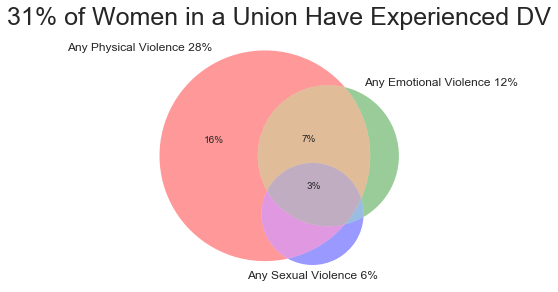

In [19]:
# Make the diagram the venn diagram
plt.figure(figsize=(5,5))
plt.title('31% of Women in a Union Have Experienced DV', fontsize=25)
v = venn3(subsets = (13.3,1.9, 5.6, .8,1.7,.2,2.8), set_labels = ('Any Physical Violence 28%', 'Any Emotional Violence 12%', 'Any Sexual Violence 6%'))
v.get_label_by_id('100').set_text('16%')
v.get_label_by_id('110').set_text('7%')
v.get_label_by_id('111').set_text('3%')
v.get_label_by_id('001').set_text('')
v.get_label_by_id('010').set_text('')
v.get_label_by_id('011').set_text('')
v.get_label_by_id('101').set_text('')
plt.show()

In [20]:
# Groups of men to convert from abusive--> not abusive, atagnonistic--> not antagonistic, not atagonistic--> advocates
df_m = df.groupby(['afraid_never','dv'])['dv'].agg(['count']).reset_index()
df_m['perc']= df_m['count']*100.0/len(df)
df_m

,afraid_never,dv,count,perc
0,0,0,30570,51.006107
1,0,1,16487,27.508593
2,1,0,10617,17.714486
3,1,1,2260,3.770815


In [21]:
# Create dfs for visualizations

# d102 is number of control issues
df_control  = df.groupby('d102')['dv'].agg(['mean','count']).reset_index()
df_control['perc'] = df_control['count']*100.0/len(df)
df_control['mean'] = df_control['mean']*100.0

# v012 is age in complete years
df_age  = df.groupby('v012')['dv'].agg(['mean','count']).reset_index()
df_age['perc'] = df_age['count']*100.0/len(df)
df_age['mean'] = df_age['mean']*100.0

# v133 is the number of years of education
df_educ = df.groupby('v133')['dv'].agg(['mean','count']).reset_index()
df_educ['perc'] = df_educ['count']*100.0/len(df)
df_educ['mean'] = df_educ['mean']*100.0

# v133 is the wealth quintile of a household
df_wealth = df.groupby('wealth')['dv'].agg(['mean','count']).reset_index()
df_wealth['perc']= df_wealth['count']*100.0/len(df)
df_wealth['mean'] = df_wealth['mean']*100.0

# v743_ questions have to do with who the respondant says has the ability to influence day to day decisions in the househol
df_house_dec = df.groupby('house_dec')['dv'].agg(['mean','count']).reset_index()
df_house_dec['perc']= df_house_dec['count']*100.0/len(df)
df_house_dec['mean'] = df_house_dec['mean']*100.0

# Number of reasons a man is justified in beating his wife
df_reasons = df.groupby('reasons')['dv'].agg(['mean','count']).reset_index()
df_reasons['perc']= df_reasons['count']*100.0/len(df)
df_reasons['mean'] = df_reasons['mean']*100.0

# Religion
df_rel = df.groupby('v130')['dv'].agg(['mean','count']).reset_index().sort_values('mean')
df_rel['perc'] = df_rel['count']*100.0/len(df)
df_rel['mean'] = df_rel['mean']*100.0
df_rel = df_rel.replace('buddhist/neo-buddhist','buddhist')
df_rel = df_rel[df_rel.v130 != 'jewish']

# Categorical Variables
# How often partner gets drunk
df_drunk = df.groupby('drunk')['dv'].agg(['mean','count']).reset_index().sort_values('mean').reset_index()
df_drunk['perc'] = df_drunk['count']*100.0/len(df)
df_drunk['mean'] = df_drunk['mean']*100.0

# Urban vs. Rural
df_urban = df.groupby('v102')['dv'].agg(['mean','count']).reset_index().sort_values('mean')
df_urban['perc']= df_urban['count']*100.0/len(df)
df_urban['mean'] = df_urban['mean']*100.0

# Earnings
df_earnings = df.groupby('earnings')['dv'].agg(['mean','count']).reset_index().sort_values('mean')
df_earnings['perc']= df_earnings['count']*100.0/len(df)
df_earnings['mean'] = df_earnings['mean']*100.0

# State
df_state = df.groupby('v101')['dv'].agg(['mean','count']).reset_index().sort_values('mean')
df_state['perc']= df_state['count']*100.0/len(df)
df_state['mean'] = df_state['mean']*100.0

# Region
df_region = df.groupby('region')['dv'].agg(['mean','count']).reset_index().sort_values('mean')
df_region['perc']= df_region['count']*100.0/len(df)
df_region['mean'] = df_region['mean']*100.0

# Ethnicity
df_ethn = df.groupby('v131')['dv'].agg(['mean','count']).reset_index().sort_values('mean')
df_ethn['perc']= df_ethn['count']*100.0/len(df)
df_ethn['mean'] = df_ethn['mean']*100.0

# Earnings Relative to Husband
df_earn_portion = df.groupby('v746')['dv'].agg(['mean','count']).reset_index().sort_values('mean')
df_earn_portion['perc']= df_earn_portion['count']*100.0/len(df)
df_earn_portion['mean'] = df_earn_portion['mean']*100.0

# News_mags
df_nm = df.groupby('v157')['dv'].agg(['mean','count']).reset_index().sort_values('mean')
df_nm['perc']= df_nm['count']*100.0/len(df)
df_nm['mean'] = df_nm['mean']*100.0

In [22]:
# If you have experienced dv, you are more likely to agree with one or more justifications for wife beating?
df_agree = pd.DataFrame(df['reasons_thresh'].groupby(df['dv']).mean()).reset_index()
display(df_agree)

,dv,reasons_thresh
0,0,0.359749
1,1,0.567611


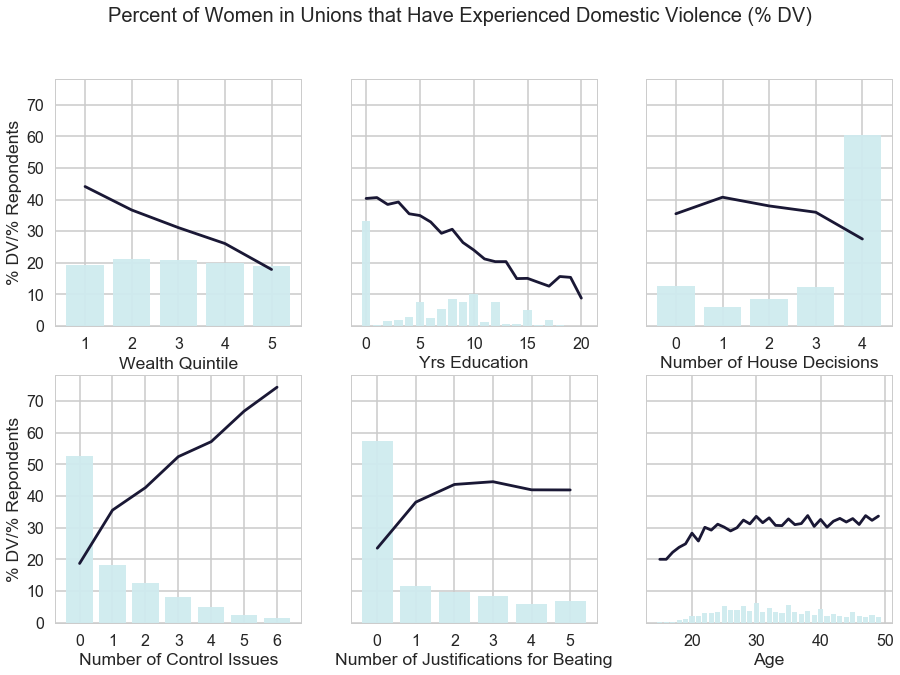

In [23]:
# Make a set of line plots for age, education, and wealth and prev of dv
# Then make a set of histograms to go along with those

m = df.dv.mean()
#plt.axhline(y=m, xmin=0, xmax=1, hold=None, color="#EE3E3A")

fig = plt.figure(figsize=(15,10))
fig.tight_layout()
st = fig.suptitle("Percent of Women in Unions that Have Experienced Domestic Violence (% DV)", fontsize=20)
#plt.subplots_adjust(hspace = 0.02)

ax1 = plt.subplot(2,3,1)
ax1.set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], minor=False)
ax1.set_ylim(0, 80)
plt.plot(df_wealth['wealth'], df_wealth['mean'], color= palette[0])
plt.bar(df_wealth['wealth'], df_wealth['perc'], color= palette[7], alpha = .95)
ax1.set_xticks([1, 2, 3, 4, 5], minor=False)
plt.ylabel('% DV/% Repondents')
plt.xlabel('Wealth Quintile')

ax2 = plt.subplot(2,3,2, sharey=ax1)
plt.plot('v133', 'mean', data=df_educ, color=palette[0])
plt.bar(df_educ['v133'], df_educ['perc'],  color= palette[7], alpha = .95)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.xlabel('Yrs Education')

ax3 = plt.subplot(2,3,3, sharey=ax1)
plt.plot('house_dec', 'mean', data=df_house_dec, color=palette[0])
plt.bar(df_house_dec['house_dec'], df_house_dec['perc'],  color= palette[7], alpha = .95)
ax3.set_xticks([0, 1, 2, 3, 4], minor=False)
plt.setp(ax3.get_yticklabels(), visible=False)
plt.xlabel('Number of House Decisions')

ax4 = plt.subplot(2,3,4, sharey=ax1)
plt.plot( 'd102', 'mean', data=df_control, color=palette[0])
plt.bar(df_control['d102'], df_control['perc'],  color= palette[7], alpha = .95)
ax4.set_xticks([0, 1, 2, 3, 4, 5, 6], minor=False)
plt.ylabel('% DV/% Repondents')
plt.xlabel('Number of Control Issues')

ax5 = plt.subplot(2,3,5, sharey=ax1)
plt.plot('reasons', 'mean', data=df_reasons, color=palette[0])
plt.bar(df_reasons['reasons'], df_reasons['perc'],  color= palette[7], alpha = .95)
ax5.set_xticks([0, 1, 2, 3, 4, 5], minor=False)
plt.setp(ax5.get_yticklabels(), visible=False)
plt.xlabel('Number of Justifications for Beating')

ax6 = plt.subplot(2,3,6, sharey=ax1)
plt.plot(df_age['v012'], df_age["mean"], color=palette[0])
plt.bar(df_age['v012'], df_age['perc'],  color= palette[7], alpha = .95)
plt.setp(ax6.get_yticklabels(), visible=False)
plt.xlabel("Age")

plt.show()

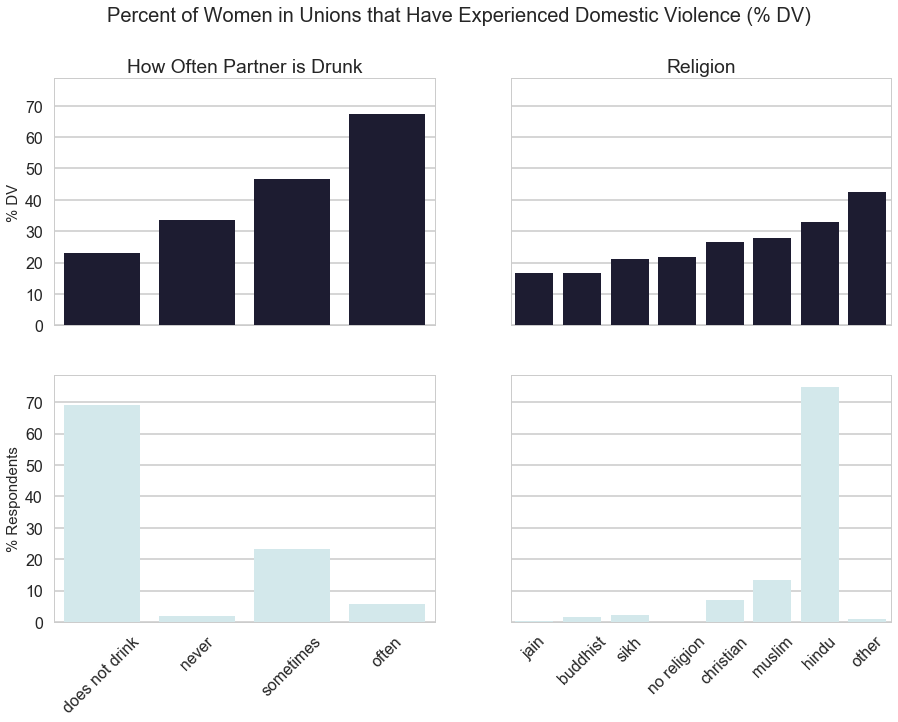

In [24]:
# Visualizations by Categorical Variables
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Percent of Women in Unions that Have Experienced Domestic Violence (% DV)", fontsize=20)
#plt.subplots_adjust(hspace = 0.57)

# How Often Husband Gets Drunk
ax1 = plt.subplot(2,2,1)
ax1.set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], minor=False)
ax1.set_ylim(0, 80)
ax1.set_ylim(0, 80)
plt.xticks(rotation=45)
plt.setp(ax1.get_xticklabels(), visible=False)
sns.barplot(x='drunk', y = 'mean', data = df_drunk ,color= palette[0])
#sns.barplot(x='drunk', y = 'perc', data = df_drunk ,color= palette[1],plot_kws={'bar_kws':{'color':'red'}})
#plt.bar(df_drunk['drunk'], df_drunk['mean'], color= palette[1])
plt.ylabel('% DV',fontsize=15)
plt.xlabel('')
plt.title('How Often Partner is Drunk')

# Drunk Histogram
ax3 = plt.subplot(2,2,3, sharey=ax1)
sns.barplot(x='drunk', y = 'perc', data = df_drunk ,color= palette[7])
plt.xticks(rotation=45)
plt.ylabel('% Respondents',fontsize=15)
plt.xlabel('')

# Religion
ax2 = plt.subplot(2,2,2, sharey=ax1)
sns.barplot(x='v130', y = 'mean', data = df_rel ,color= palette[0])
plt.xticks(rotation=45)
plt.ylabel('% DV',fontsize=15)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.xlabel('')
plt.ylabel('')
plt.title("Religion")

# Religion Histogram
ax4 = plt.subplot(2,2,4, sharey=ax1)
sns.barplot(x='v130', y = 'perc', data = df_rel ,color= palette[7])
plt.xticks(rotation=45)
plt.ylabel('% Respondents',fontsize=15)
plt.setp(ax4.get_yticklabels(), visible=False)
plt.xlabel('')
plt.ylabel('')

plt.show()

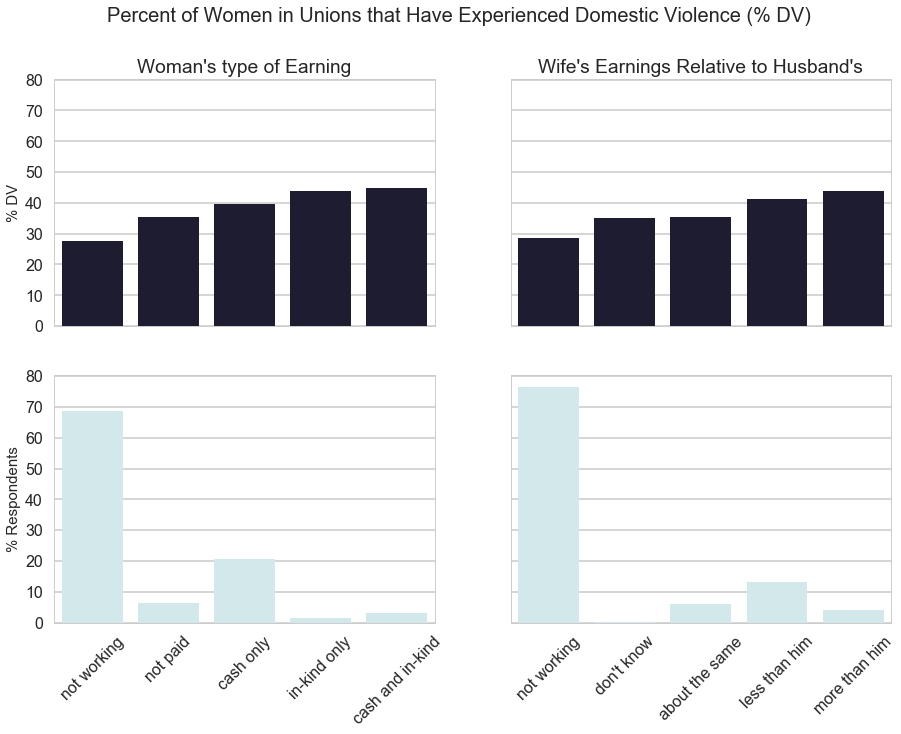

In [25]:
# Visualizations by Categorical Variables
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Percent of Women in Unions that Have Experienced Domestic Violence (% DV)", fontsize=20)
#plt.subplots_adjust(hspace = 0.57)

# Woman's Type of Earning
ax1 = plt.subplot(2,2,1)
ax1.set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], minor=False)
ax1.set_ylim(0, 80)
ax1.set_ylim(0, 80)
plt.xticks(rotation=45)
sns.barplot(x='earnings', y = 'mean', data = df_earnings ,color= palette[0])
plt.setp(ax1.get_xticklabels(), visible=False)
plt.ylabel('% DV',fontsize=15)
plt.xlabel('')
plt.title("Woman's type of Earning")

# Woman's type of earning histogram
ax3 = plt.subplot(2,2,3, sharey=ax1)
sns.barplot(x='earnings', y = 'perc', data = df_earnings ,color= palette[7])
plt.xticks(rotation=45)
plt.setp(ax4.get_yticklabels(), visible=False)
plt.ylabel('% Respondents',fontsize=15)
plt.xlabel('')

# Earn Portion
df_earn_portion = df_earn_portion.replace({0:"not working"})
ax2 = plt.subplot(2,2,2, sharey=ax1)
sns.barplot(x='v746', y = 'mean', data = df_earn_portion ,color= palette[0])
plt.xticks(rotation=45)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
#plt.ylabel('% DV',fontsize=15)
plt.ylabel('')
plt.xlabel('')
plt.title("Wife's Earnings Relative to Husband's")

#Earn Portion Histogram
ax4 = plt.subplot(2,2,4, sharey=ax1)
sns.barplot(x='v746', y = 'perc', data = df_earn_portion ,color= palette[7])
plt.xticks(rotation=45)
plt.setp(ax4.get_yticklabels(), visible=False)
#plt.ylabel('% Respondents',fontsize=15)
plt.xlabel('')
plt.ylabel('')

plt.show()


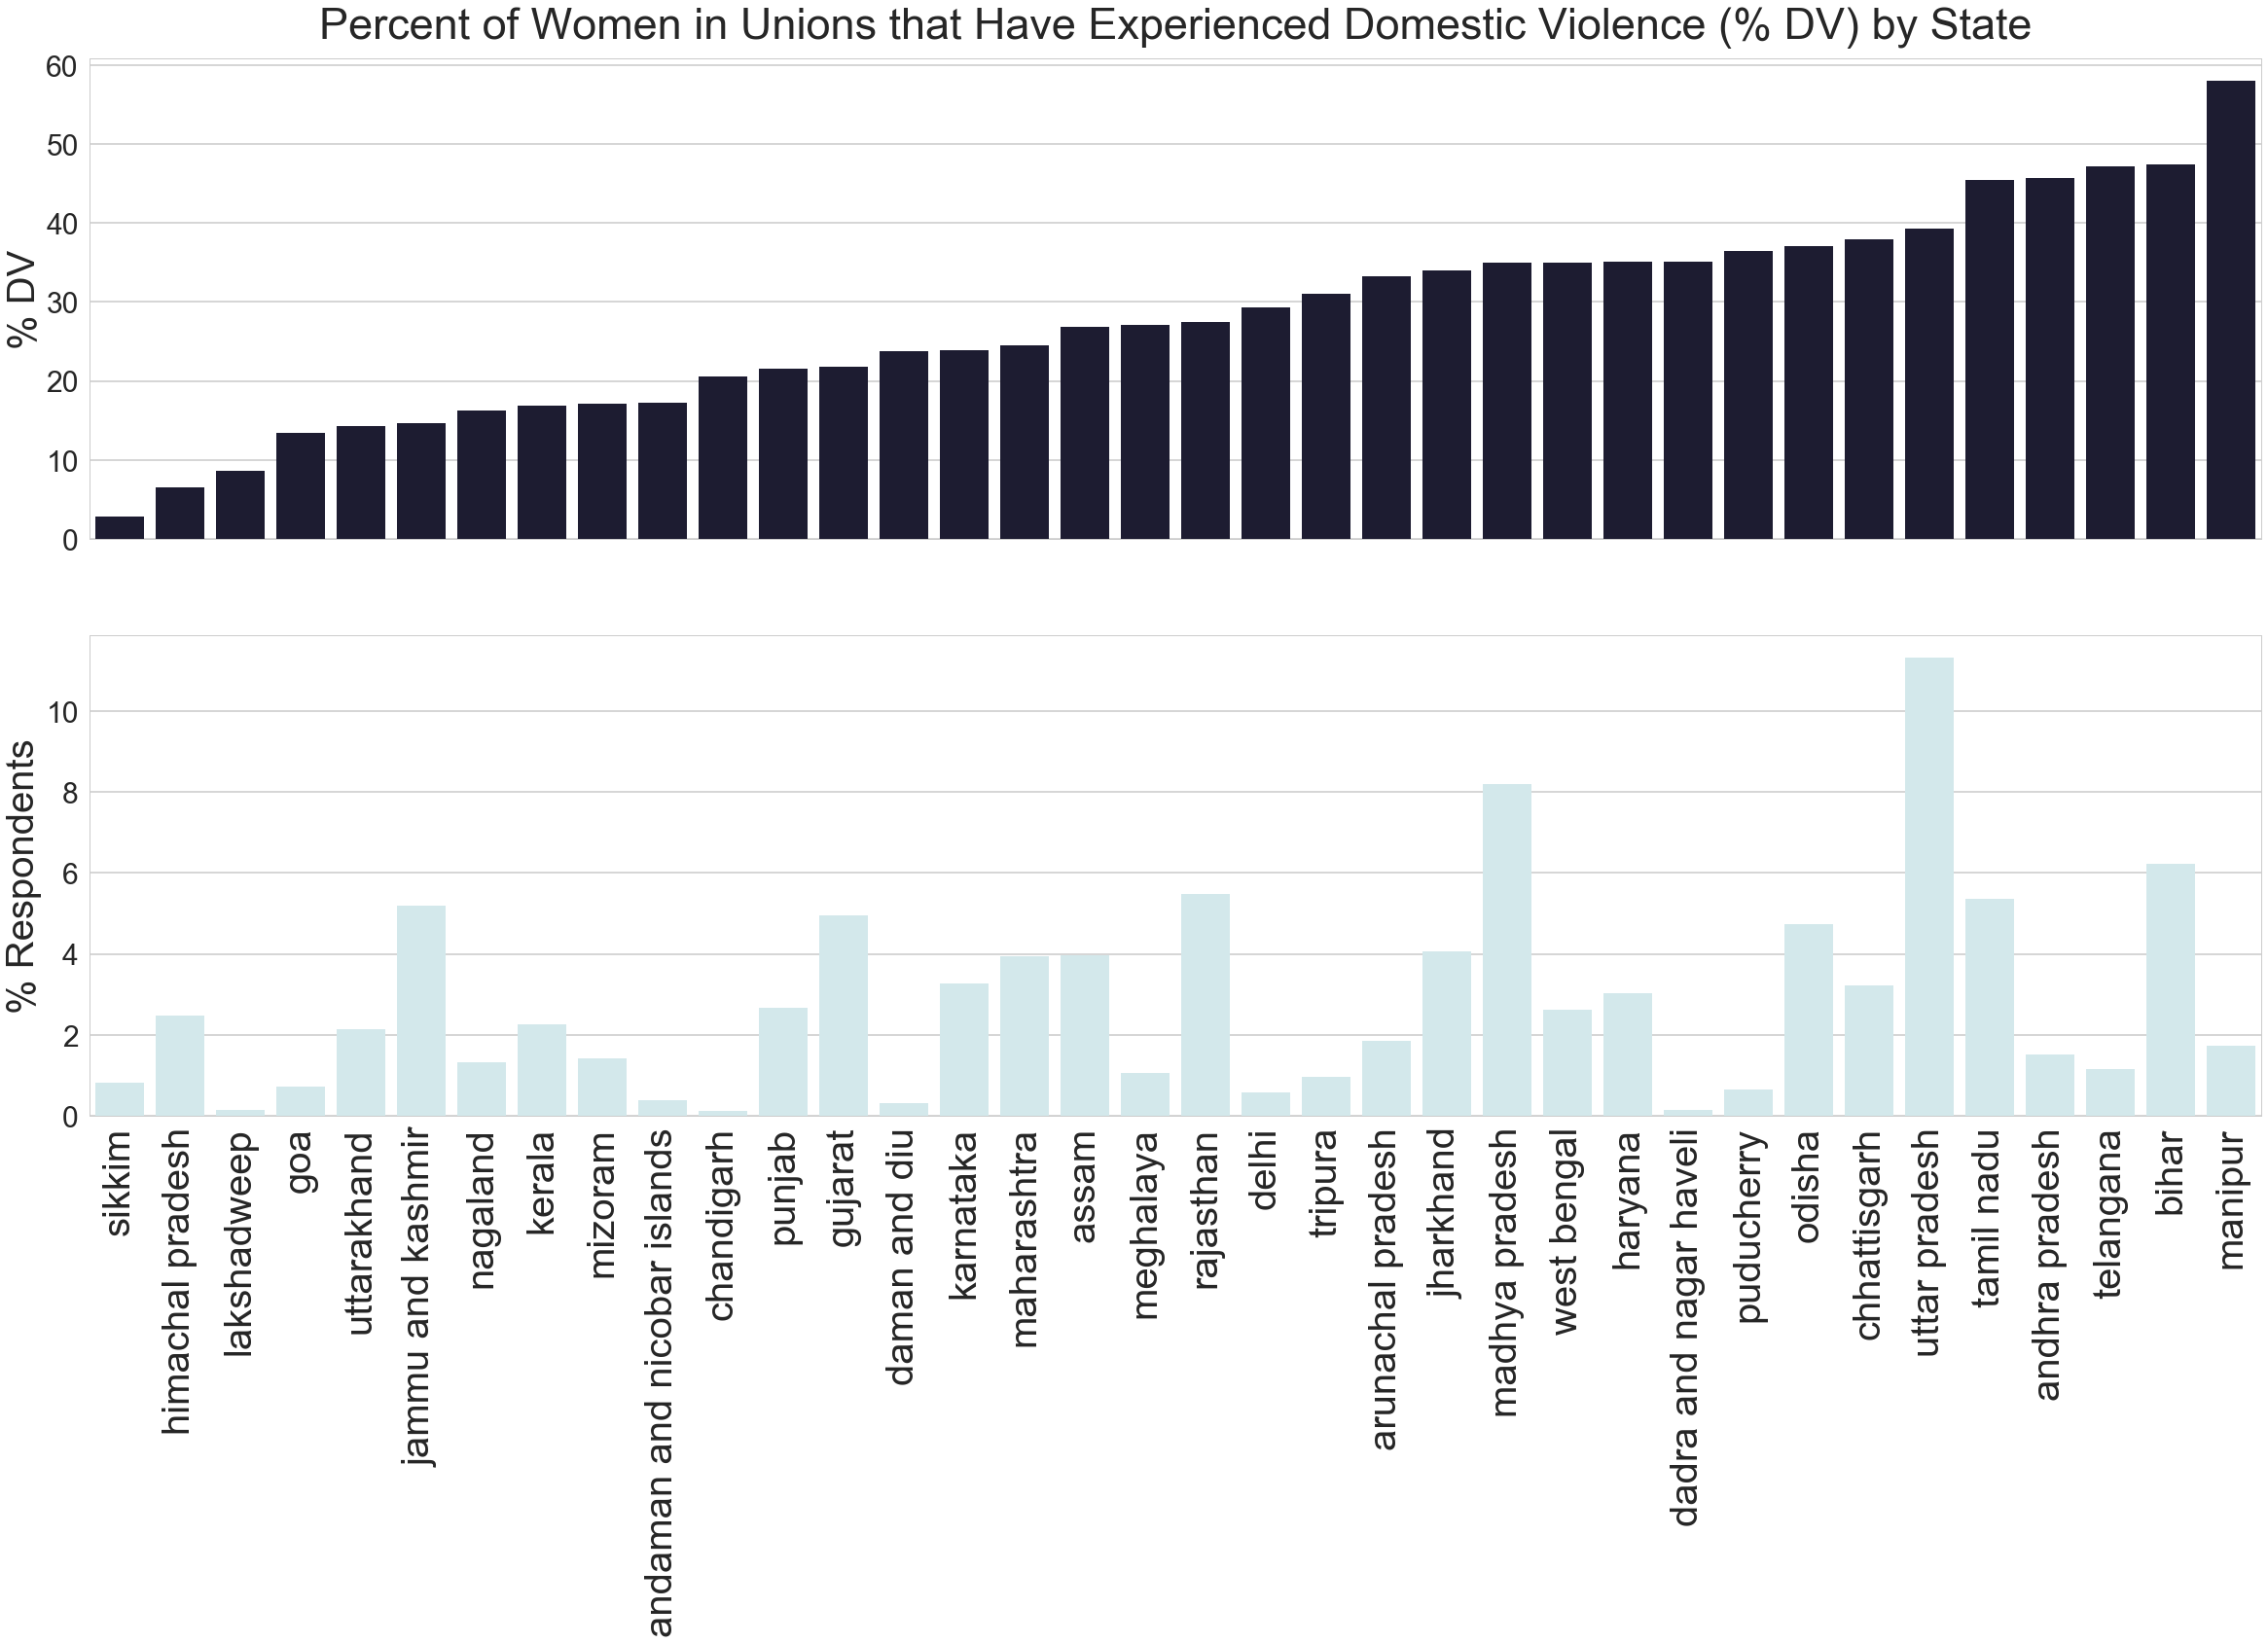

In [26]:
# State
fig = plt.figure(figsize=(40,20))
#st = fig.suptitle("Percent of Women in Unions that Have Experienced Domestic Violence (% DV)", fontsize=20)
#plt.subplots_adjust(hspace = 0.57)

# Woman's Type of Earning
ax1 = plt.subplot(2,1,1)
#plt.figure(figsize=(30,15))
sns.barplot(x='v101', y='mean', data=df_state, color = palette[0])
#plt.xticks(rotation=90, fontsize = 40)
plt.yticks(fontsize = 30)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.title('Percent of Women in Unions that Have Experienced Domestic Violence (% DV) by State', fontsize = 45, y=1.03)
plt.ylabel('% DV', fontsize = 40)
plt.xlabel('')

ax2 = plt.subplot(2,1,2)
#plt.figure(figsize=(30,15))
sns.barplot(x='v101', y='perc', data=df_state, color = palette[7])
plt.xticks(rotation=90, fontsize = 40)
plt.yticks(fontsize = 30)
plt.ylabel('% Respondents', fontsize = 40)
plt.xlabel('')

plt.show()

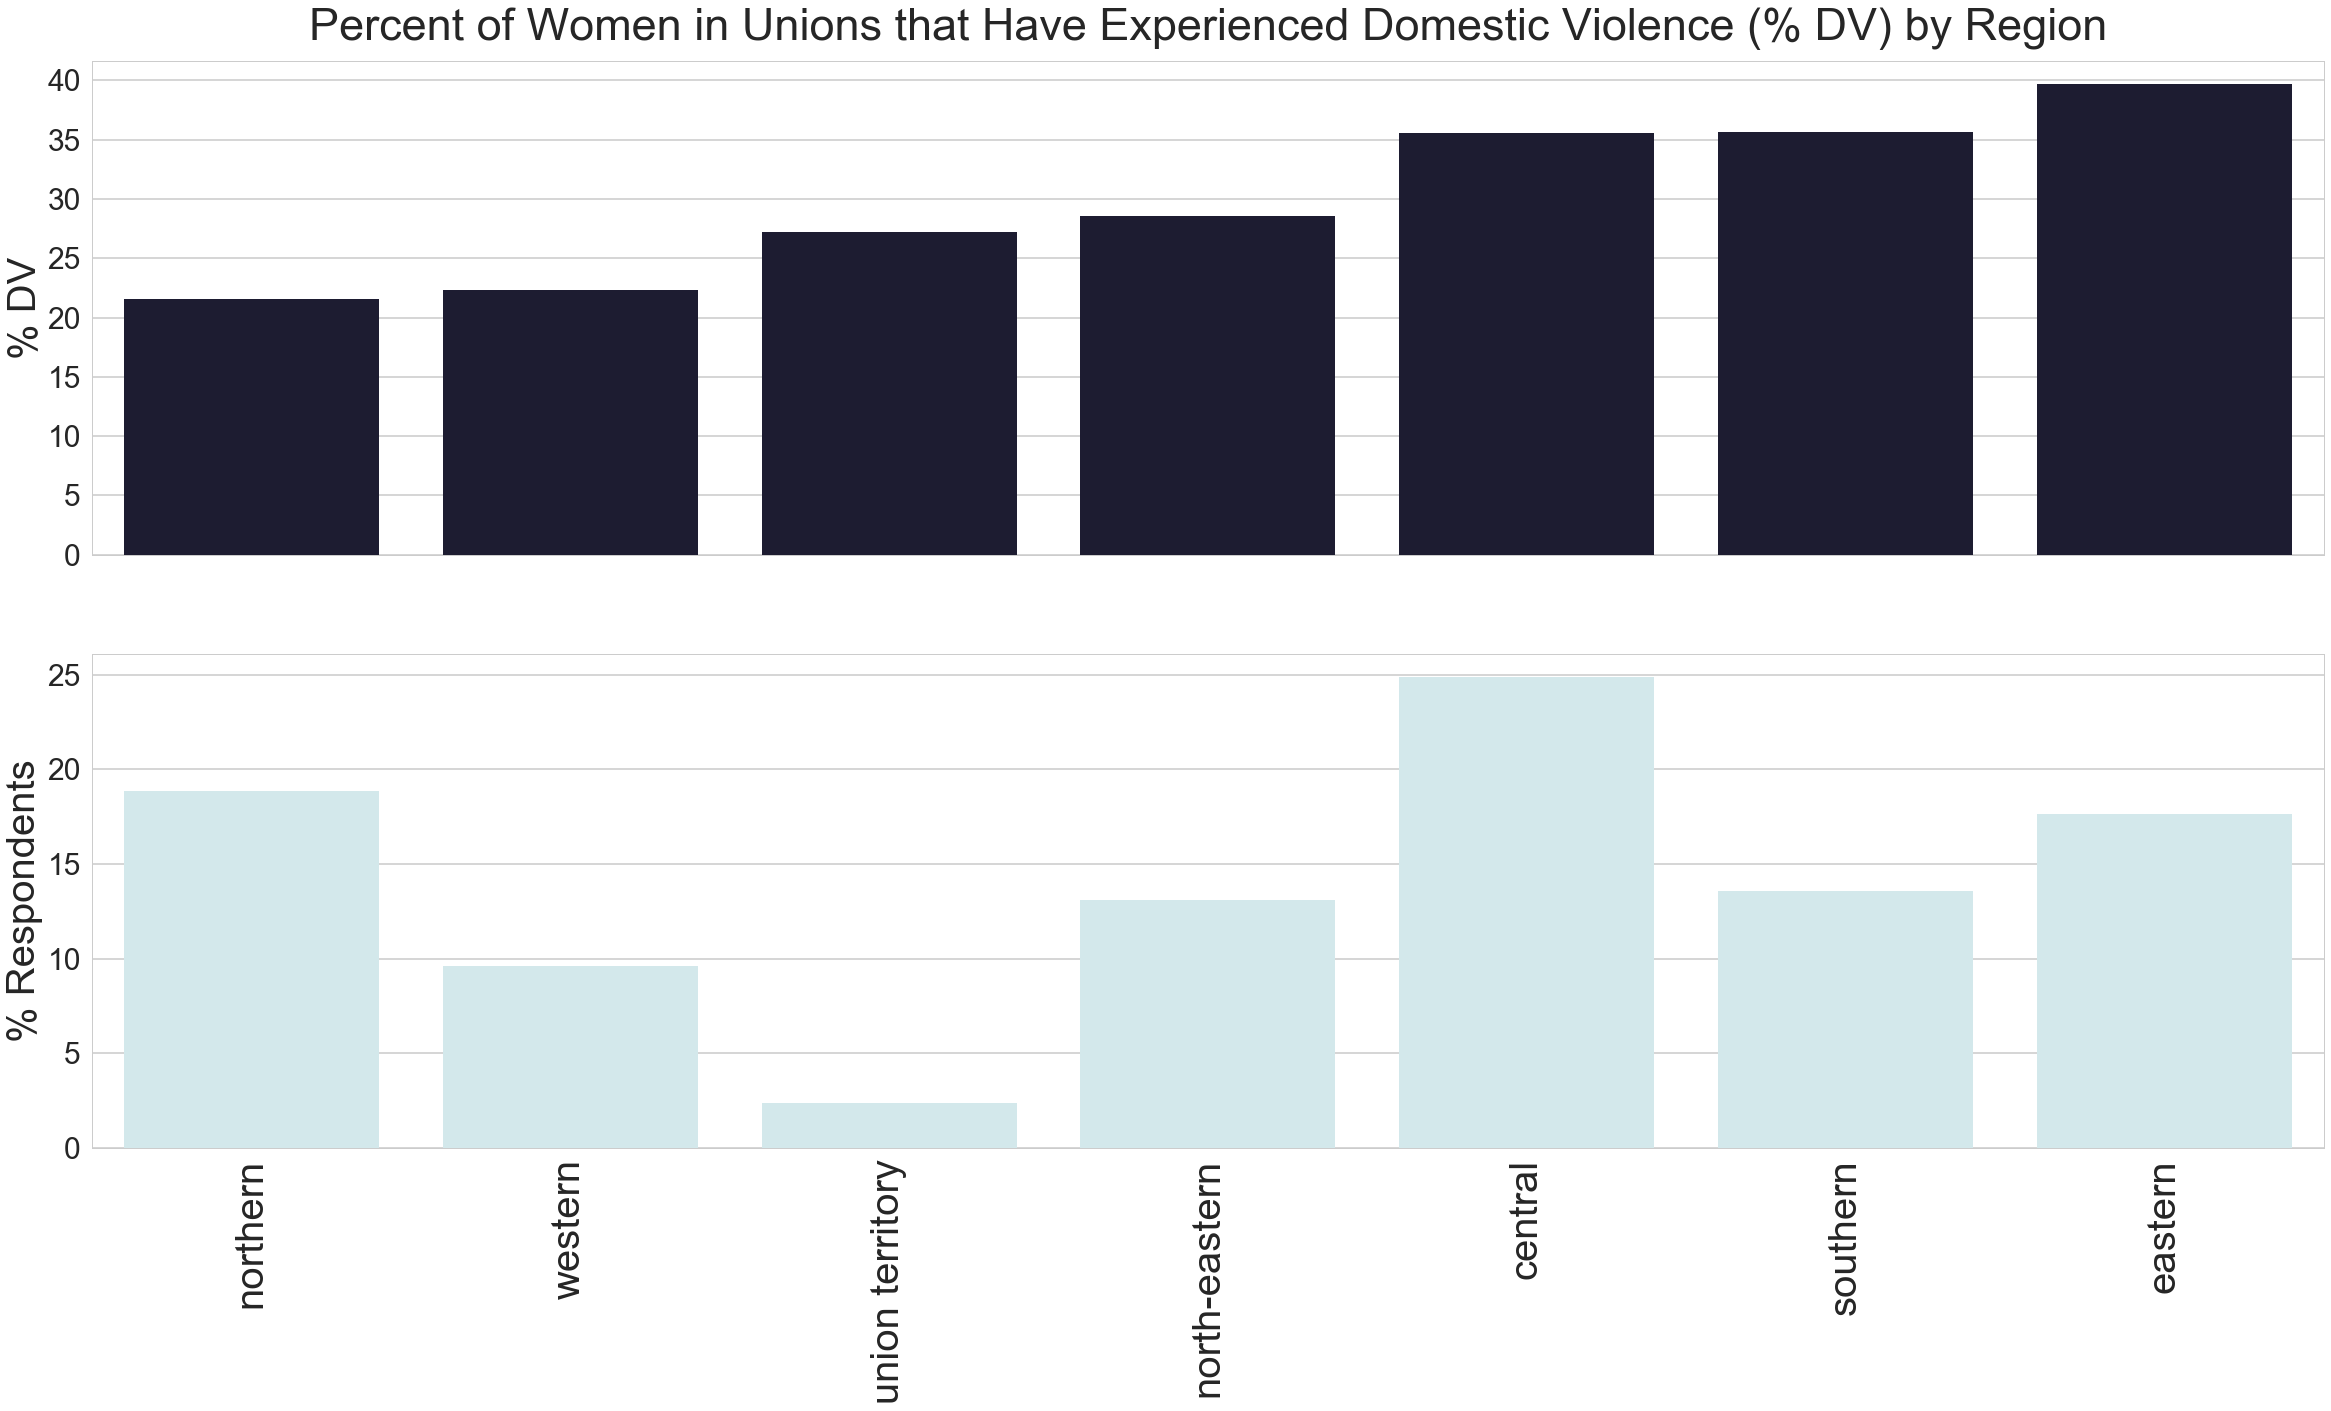

In [27]:
# Region
fig = plt.figure(figsize=(40,20))
#st = fig.suptitle("Percent of Women in Unions that Have Experienced Domestic Violence (% DV)", fontsize=20)
#plt.subplots_adjust(hspace = 0.57)

# Woman's Type of Earning
ax1 = plt.subplot(2,1,1)
#plt.figure(figsize=(30,15))
sns.barplot(x='region', y='mean', data=df_region, color = palette[0])
#plt.xticks(rotation=90, fontsize = 40)
plt.yticks(fontsize = 30)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.title('Percent of Women in Unions that Have Experienced Domestic Violence (% DV) by Region', fontsize = 45, y=1.03)
plt.ylabel('% DV', fontsize = 40)
plt.xlabel('')

ax2 = plt.subplot(2,1,2)
#plt.figure(figsize=(30,15))
sns.barplot(x='region', y='perc', data=df_region, color = palette[7])
plt.xticks(rotation=90, fontsize = 40)
plt.yticks(fontsize = 30)
plt.ylabel('% Respondents', fontsize = 40)
plt.xlabel('')

plt.show()

### Categorical Variables

In [28]:
# Sorting objects variables into categories to be dealt with accordingly
objs = list(df.select_dtypes(include=['object']).dtypes.to_frame().index)

# List of ordinal variables
ords = ['v745b','v745a','v503','v504','v505','d115','v153','d115y','v746'
        ,'v743f', 'v743d', 'v743b', 'v743a','v741', 'v731', 'd129', 'd114'
        ,'v715', 'v190','d101f', 'drunk','earnings','d121','d119y','d117a'
        ,'d124','d109','d125','v155']

# List of categorical variables
cats = ['v130','v131','v101','region']

# List to drop during clustering (columns no longer needed, mostly bc of engineered features)
drops = ['v044','caseid','v501','v502', 'v190', 'v102','dv_co'
         ,'v744e', 'v744d', 'v744c', 'v744b', 'v744a','v743f','v743d'
         ,'v743b','v743a','d101f','d101e', 'd101d', 'd101c', 'd101b'
         , 'd101a','v741','drunk','earnings','v034','v121','v120','v157', 'v158','v159','v155']
drops = [item for item in drops if item in df.columns.unique()]

# List of unsorted object variables
print("Still need to sort these before moving on: ",[item for item in objs if item not in (ords + cats + drops)]) 


Still need to sort these before moving on:  []


In [29]:
# Drop list of columns called "drops"
df = df.drop(drops, axis=1)
df.shape

(59934, 81)

In [30]:
# Label encode categorical variables
for cat in cats:
    name = cat
    le = LabelEncoder()
    le.fit(df[cat])
    df[name] = le.transform(df[cat])
    print(name,":",df[name].unique())
    

v130 : [2 1 5 0 6 7 8 3 4]
v131 : [2 0 3 1]
v101 : [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
  9 25 26 27 28 29 30 32 33 34 35 31]
region : [5 4 2 1 0 6 3]


In [31]:
# Function that takes an object variable to be converted to binary and a list of values that should be converted to 1s.
def binarify(var, ones):
    
    unique_values = df[var].unique()
    
    zeros = [value for value in unique_values if value not in ones]

    # Only do this transformation if has not already been done
    if df[var].dtype == np.object:

        # Replace values to be numeric and remove na's
        df[var] = np.where(df[var].isin(ones), 1, 0)

        # Select the by row/column pair to select single value and udate the definition
        #data_dict.at[var,'changes'] = '1 = ' + str(ones) + '0 = ' + str(zeros)

        # Current values
        print("New unique values for variable",var,": ", df[var].unique())
        
        # List values that still need to be addressed
        current_objs = list(df.select_dtypes(include=['object']).dtypes.to_frame().index)
        need_to_binarify = [col for col in ords if col in current_objs]
        print("Ordinals still need to take care of: ", need_to_binarify)

    else:
        # Let user know this variable is already taken care of
        print("Variable", var ," already numerical. Values are: ", df.v745b.unique())
        
        # List values that still need to be addressed
        current_objs = list(df.select_dtypes(include=['object']).dtypes.to_frame().index)
        need_to_binarify = [col for col in ords if col in current_objs]
        print("Ordinals still need to take care of: ", need_to_binarify)

In [32]:
# v745b
binarify('v745b', ['alone only', 'both alone and jointly','jointly only'])

# v745a
binarify('v745a',['both alone and jointly', 'jointly only', 'alone only'])

# v503
binarify('v503',['once','more than once'])

# v504
binarify('v504', ['living with her'])

# v504
binarify('v505', ['1.0','2.0','3.0','4.0','5.0','6.0','7.0','8.0','9.0'])

# d115y
binarify('d115y',['someone physically hurt respondent'])

# v746
binarify('v746',['more than him'])

# v731 Whether the respondent worked in the last 12 months  
binarify('v731',['currently working', 'in the past year', 'have a job, but on leave last 7 days'])

# d121 Did her father ever beat her mother.
binarify('d121',[1])

# d124, which says if anyone other that partner forced respondant to perform sexual acts
binarify('d124',[1])

# d125 Anyone forced respondent to perform sexual acts. [0, 1, refused to answer/no response]
binarify('d125',[1])

# Ever told anyone else about violence?
df['d128'] = df['d128'].replace({np.nan:0})

New unique values for variable v745b :  [0 1]
Ordinals still need to take care of:  ['v745a', 'v503', 'v504', 'v505', 'd115y', 'v746', 'v731', 'v715', 'd121', 'd124', 'd125']
New unique values for variable v745a :  [0 1]
Ordinals still need to take care of:  ['v503', 'v504', 'v505', 'd115y', 'v746', 'v731', 'v715', 'd121', 'd124', 'd125']
New unique values for variable v503 :  [1]
Ordinals still need to take care of:  ['v504', 'v505', 'd115y', 'v746', 'v731', 'v715', 'd121', 'd124', 'd125']
New unique values for variable v504 :  [1 0]
Ordinals still need to take care of:  ['v505', 'd115y', 'v746', 'v731', 'v715', 'd121', 'd124', 'd125']
New unique values for variable v505 :  [0 1]
Ordinals still need to take care of:  ['d115y', 'v746', 'v731', 'v715', 'd121', 'd124', 'd125']
New unique values for variable d115y :  [0 1]
Ordinals still need to take care of:  ['v746', 'v731', 'v715', 'd121', 'd124', 'd125']
New unique values for variable v746 :  [0 1]
Ordinals still need to take care of:

In [33]:
display_count(['v715'])

,variable,type,dependent,description,unique_values,dtype,final_use,short_description
80,v715,segment,v501,V715 Most recent husband or partner's educatio...,"[5.0, 12.0, 17.0, 15.0, 9.0, 0.0, 6.0, 11.0, 1...",object,NaN,education_partner


In [34]:
# Mean years of education of partner
#part_educ = df.v715
part_educ = df['v715'][df['v715'] != "don't know"].astype('float')
mean_part_educ = np.mean(part_educ)

# Number of years of education of most recent partner/husband
df['v715'] = np.where(df.v715 == "don't know", mean_part_educ, df.v715).astype('float')

In [35]:
# Check that no segementation columns are objects
print(df.shape)
objs = list(df.select_dtypes(include=['object']).dtypes.to_frame().index)
print(objs)

(59934, 81)
[]


# K Means Clustering

In [36]:
# Split variables into groups for segmentation ('xs') and profiling ('profs')
xs = ['dv_phys_level', 'dv_sex','dv_emo', 'd129', 'control','v','d121','reasons_thresh']
profs = ['dv','v','d106','d107','dv_sex','dv_emo','afraid_most','afraid_sometimes','afraid_never','d102','reasons_thresh'
         ,'d128','v012','v153','v731','hh_health','can_read','news_mags','tv','radio','news_mags_never','tv_never','radio_never'
         ,'wealth','does_not_drink', 'v715','v730', 'v133','urban']

# If variable is in xs or profs, add that info to the data_dict
data_dict['final_use'] = np.where(data_dict.variable.isin(xs),'xs',np.where(data_dict.variable.isin(profs),'profs',np.nan))

# Creat df_xs, the df to segment respondents on and view data_dict
df_c = df
df_xs = df_c[xs]
display_count(xs)

,variable,type,dependent,description,unique_values,dtype,final_use,short_description
17,d121,segment,NaN,D121 Did her father ever beat her mother.,"[0, 1]",int64,xs,v_between_parents
31,d129,segment,v502,D129 Respondent afraid of husband/partner most...,"[0, 1, 2]",int64,xs,afraid
39,dv_phys_level,NaN,NaN,levels of physical violence,"[0, 1, 2]",int64,xs,NaN
41,dv_emo,NaN,NaN,presence of emotional violence,"[0, 1]",int64,xs,NaN
43,reasons_thresh,NaN,NaN,if respondent agrees with one or more justific...,"[0, 1]",int64,xs,NaN
50,control,NaN,NaN,Number of control behaviors respondents partne...,"[0.0, 0.667, 1.333, 0.333, 1.0, 1.667, 2.0]",float64,xs,NaN
63,dv_sex,NaN,NaN,presence of sexual violence,"[0, 1]",int64,xs,NaN
65,v,NaN,NaN,If woman reported any violence from someone ot...,"[0, 1]",int64,xs,NaN


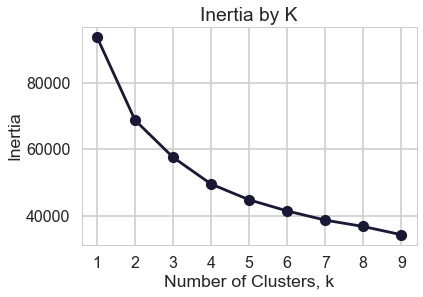

Duration: 0:00:07.341381


In [37]:
#Record start time of processing
start = datetime.datetime.now()

# The best values of SS are found at the "Elbow." 
# The lower the SS, the less distance between data points and their centroid. 
# However, as you increase K, you are bound to decrease SS, but at somepoint overfitting begins.
ks = range(1, 10)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters = k)
    
    # Fit model to samples
    model.fit(df_xs)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.title('Inertia by K')
plt.xlabel('Number of Clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

# Record end time of processing and print duration
end = datetime.datetime.now()
print("Duration:", end - start)

In [38]:
# Choose best k by the "elbow" method
best_k = 3

# Add bar chart showing the number of points in each cluster for k-means under the best K

# The slope flattens near 3, so best k = 3. Create model, cluster, with n_clusters = 3.
cluster = KMeans(n_clusters = best_k)

# Add a column to df that is cluster labels from fitting and predicting cluster on df_xs
df_c['cluster'] = cluster.fit_predict(df_xs)

# Find counts of respondents in each cluster
cluster_counts = pd.DataFrame(df_c.groupby('cluster')['d005'].count()).reset_index().rename(index=str, columns={'d005':'cluster_count'}).sort_values('cluster_count')
cluster_counts['cluster_perc'] = np.round((cluster_counts['cluster_count']*100/len(df_c)),1)

# What do different clusters look like?
df_results = np.round(df_c[profs].groupby(df_c['cluster']).mean(),2).reset_index()
df_results['cluster'] = df_results['cluster'].astype('int64')
df_results = pd.merge(df_results, cluster_counts, left_on = 'cluster', right_on = 'cluster')

# Make prettier
df_results = df_results[['cluster','cluster_perc']+profs].rename(index=str, columns=col_name_dict)
df_results['category'] = np.where(df_results['dv']==np.max(df_results['dv']),'Abused',
                                 np.where(df_results['afraid_sometimes']==np.max(df_results['afraid_sometimes']),'In Danger',
                                 'Less Harmed'))
transposed_results = df_results[['category']+ list(df_results.columns.unique())].transpose()
transposed_results


,0,1,2
category,Abused,In Danger,Less Harmed
cluster,0,1,2
cluster_perc,24.2,55.3,20.4
dv,1,0.08,0.13
v,0.09,0.02,0.02
dv_phys_less,0.98,0.03,0.1
dv_phys_more,0.31,0,0
dv_sex,0.21,0.02,0.02
dv_emo,0.39,0.03,0.03
afraid_most,0.29,0.12,0


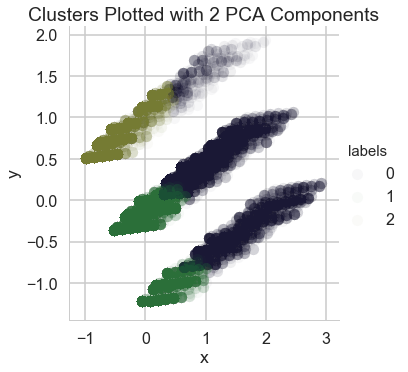

In [39]:
# This function outputs pca_plot with input of matrix, x_col and clf is clustering method
def plot_pca():
    labels = df_c['cluster']
    pca = PCA(n_components = 2)
    pca.fit(df_xs)
    new_matrix = pd.DataFrame(pca.transform(df_xs))
    new_matrix.index = df_xs.index
    new_matrix.columns = ['x','y']
    new_matrix['labels'] = labels

    sns.lmplot(x='x', y='y', hue='labels', data=new_matrix, fit_reg=False, size=5, scatter_kws={'alpha':.03}
               ,palette={0:palette[0], 2:palette[3],1:palette[2]}
              )

# Plot with best_k clusters
plot_pca()
plt.title('Clusters Plotted with 2 PCA Components')
plt.show()

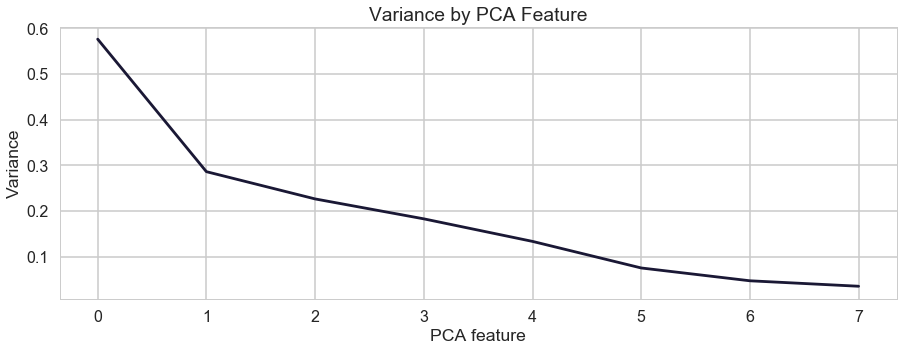

In [40]:
# Create a PCA instance: pca
pca = PCA()

# Fit to x_cols
pca.fit(df_xs)

# Plot the explained variances (Extract the number of components used using the .n_components_ attribute of pca. Place this inside a range() function and store the result as features.)
features = range(pca.n_components_)
plt.figure(figsize=(15,5))
plt.plot(features, pca.explained_variance_)
plt.title('Variance by PCA Feature')
plt.xlabel('PCA feature')
plt.ylabel('Variance')
plt.xticks(features)
plt.show()


# Classification
In addition to understanding the ways women expereince domestic violence, we also want to understand what the most important risk factors are. (Maybe what are underlying drivers? What are potential measure for prevention?)



In [41]:
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    auc_roc = roc_auc_score(y_test, predictions)
    accuracy = sum(np.where(predictions==y_test,1,0))/len(y_test)
    precision = sum(np.where((predictions==y_test) & (predictions== 1),1,0))/sum(predictions)
    recall = sum(np.where((predictions==y_test) & (predictions== 1),1,0))/sum(y_test)
    f1 = (2 * precision * recall)/(precision + recall)
    pos_preds = np.mean(predictions)
    pos_actuals = np.mean(y_test)
    false_negatives = sum(np.where((predictions == 0) & (y_test == 1),1,0))/len(y_test)
    false_positives = sum(np.where((predictions == 1) & (y_test == 0),1,0))/len(y_test)
    
    print('')
    print('Model Performance')
    print('AUC ROC: {:0.1f}'.format(round(auc_roc*100,1)))
    print('F1: {:0.1f}'.format(round(f1*100,1)))
    print('Accuracy: {:0.1f}'.format(round(accuracy*100,1)),'%')
    print('Recall: {:0.1f}'.format(round(recall*100,1)),'%')
    print('Precision: {:0.1f}'.format(round(precision*100,1)),'%')
    print('Positive Predictions: {:0.1f}'.format(round(pos_preds*100,1)),'%')
    print('Positive Actuals: {:0.1f}'.format(round(pos_actuals*100,1)),'%')
    print('False Negatives: {:0.1f}'.format(round(false_negatives*100,1)),'%') 
    print('False Positives: {:0.1f}'.format(round(false_positives*100,1)),'%')

In [42]:
# Define features of interest
xs = ['v012',
    'v746',
    'v730',
    'd121',
    'v715',
    'v714',
    'v133',
    'd102',
    'reasons_thresh',
    'house_dec',
    'drunk_freq',
    'does_not_drink',
    'urban',
    'wealth',
    'news_mags_never',
    'v130',
    #'v101'
    'region'
     ]

# Create arrays for the features and the target: X, y
# Need to add to rename list so they show up correctly in plot
X, y = df.loc[:,xs].rename(index=str, columns=col_name_dict), df.loc[:,'any_v']

# Create the training and test sets
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=.2, random_state=123)

# XGB requires dmatrix format
#X_train = xgb.DMatrix(X_train, feature_names = list(X_train.columns.unique()))
#y_train = xgb.DMatrix(y_train, feature_names = list(pd.DataFrame(y_train).columns.unique()))
#X_test = xgb.DMatrix(X_test, feature_names = list(X_test.columns.unique()))
#y_test = xgb.DMatrix(y_test, feature_names = list(pd.DataFrame(y_test).columns.unique()))

## Gradient Boosting Classifier

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  9.5min finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, early_stopping_rounds=10, eval_metric='auc',
       gamma=0, learning_rate=0.02, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1)
{'colsample_bytree': 0.3, 'max_depth': 5}
0.7949793124676054

Evaluating Randomized Search Model

Model Performance
AUC ROC: 67.8
F1: 55.0
Accuracy: 75.3 %
Recall: 46.3 %
Precision: 67.8 %
Positive Predictions: 22.3 %
Positive Actuals: 32.7 %
False Negatives: 17.5 %
False Positives: 7.2 %


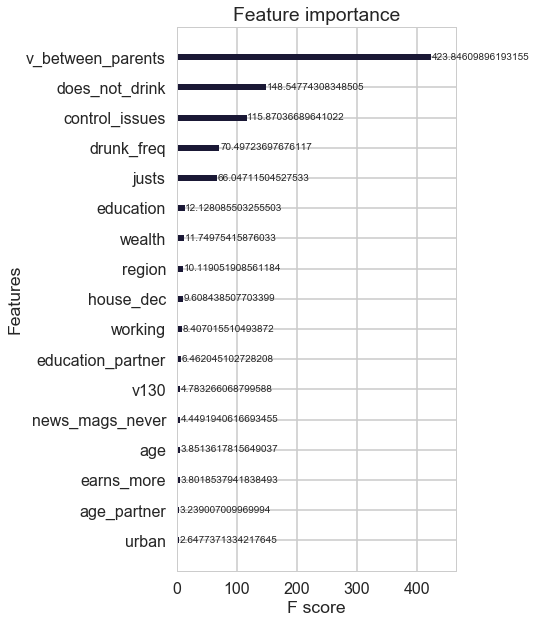

In [49]:
# Instantiate the XGBClassifier: xg_cl
xg_cl = xgb.XGBClassifier(objective='binary:logistic',
                          seed=42, 
                          learning_rate=0.02, 
                          eval_metric='auc',
                          early_stopping_rounds=10,
                          n_estimators=500
                        )

# Parameter Grid
params = {'max_depth':[1, 5, 7, 10],
          'colsample_bytree':[.1, .3, .5, .75]}

# Grid Search
mse = GridSearchCV(estimator = xg_cl, 
                   param_grid = params,
                   scoring='roc_auc',
                   cv=3,
                   verbose=1)

# Fit the classifier to the training set
mse.fit(X_train, y_train)

# Print Best Parameters Found
print(mse.best_estimator_)
best_params = mse.best_params_
print(mse.best_params_) 
print(mse.best_score_)
print('')

print('Evaluating Randomized Search Model')
best = mse.best_estimator_
evaluate(best, X_test, y_test)

# Feature Importance
#print(best.feature_importances_)
fig, ax = plt.subplots(figsize=(5, 10))
plot_importance(best, ax=ax, importance_type='gain')
plt.show()

Training GBRT...
 done.


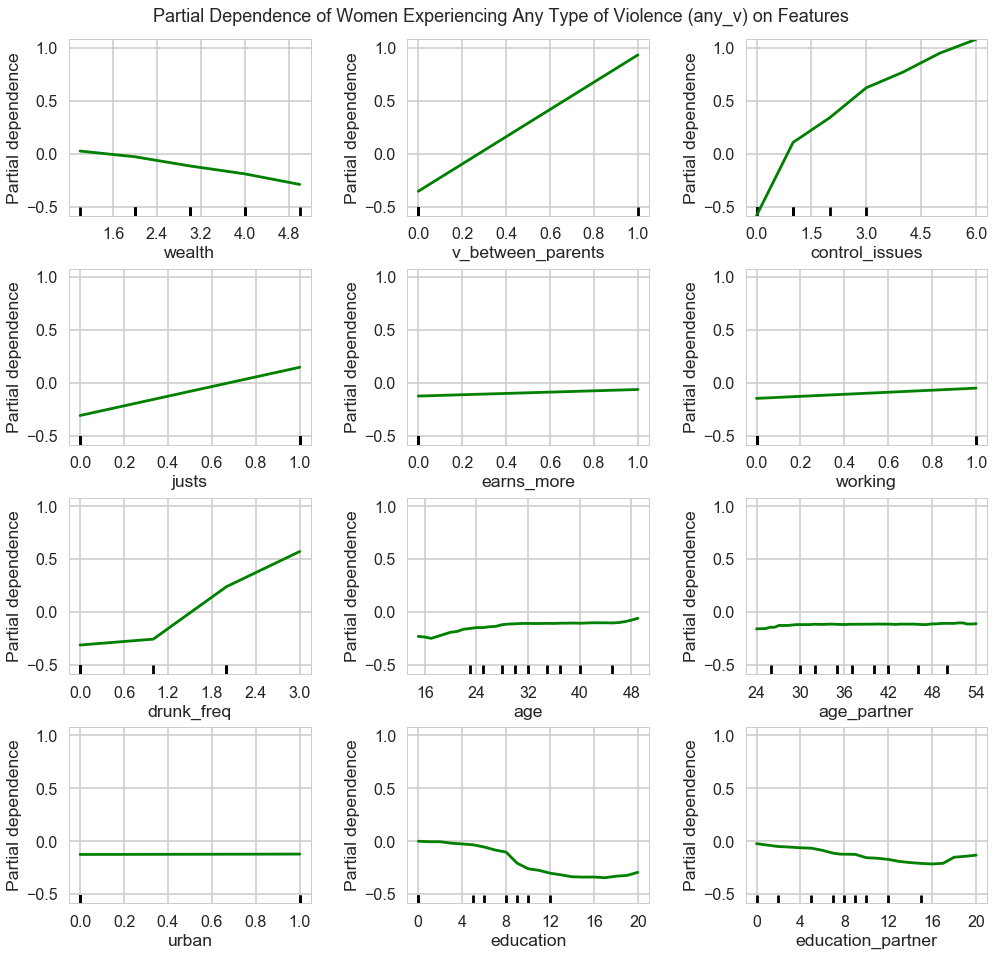

In [50]:
def main():
    names = list(X.columns.unique())

    print("Training GBRT...")
    
    # Use same specifications as for "best"
    clf = GradientBoostingClassifier(
                                     #colsample_bytree=0.5,
                                     max_features=.5,
                                     max_depth=7,
                                     #early_stopping_rounds=10,
                                     validation_fraction=0.2,
                                     n_iter_no_change=10,
                                     #eval_metric='auc',
                                     learning_rate=0.02, 
                                     n_estimators=100, 
                                     random_state=42,
                                     subsample=1
                                    )
    
    
    clf.fit(X_train, y_train)
    print(" done.")

    features = [13,3,7,8,1,5,10,0,2,12,6,4]
    fig, axs = plot_partial_dependence(clf, X_train, features,
                                       feature_names=names,
                                       n_jobs=3, 
                                       grid_resolution=50,
                                       figsize = (15,15)
                                      )
    fig.suptitle('Partial Dependence of Women Experiencing Any Type of Violence (any_v) on Features\n', fontsize=18)
    plt.subplots_adjust(top=0.95)  # tight_layout causes overlap with suptitle

    plt.show()

main()

## CatBoost Classifier

In [52]:
# To find list of indexes for categorical variables
for counter, value in enumerate(list(X_train.columns)):
    print(counter, value)

0 age
1 earns_more
2 age_partner
3 v_between_parents
4 education_partner
5 working
6 education
7 control_issues
8 justs
9 house_dec
10 drunk_freq
11 does_not_drink
12 urban
13 wealth
14 news_mags_never
15 v130
16 region


In [53]:
# Helpful article: https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db

# Record start time
start = datetime.datetime.now()

# List indices for categorical features
cat_cols_index = [1,3,5,8,10,11,12,13,14,15,16]

# Define parameter grid
params = {'depth': [4, 7, 10],
          'learning_rate' : [0.03, 0.1, 0.15],
          'l2_leaf_reg': [1,4,9],
          'iterations': [100]}

# Instantiate the CatBoostClassifier
cbc = cb.CatBoostClassifier(eval_metric="AUC", cat_features= cat_cols_index)


# GridSearch
cb_model = GridSearchCV(cbc, params, scoring="roc_auc", cv = 3)

# Fit the classifier to the training set
cb_model.fit(X_train, y_train)

# Record end time and calc duration
end = datetime.datetime.now()
print("Duration:", end - start)

# Print Best Parameters Found
print(cb_model.best_estimator_)
best_params = cb_model.best_params_
print(cb_model.best_params_) 
print(cb_model.best_score_)
print('')

print('Evaluating Randomized Search Model')
best = cb_model.best_estimator_
evaluate(best, X_test, y_test)

0:	total: 37.4ms	remaining: 3.7s
1:	total: 71.9ms	remaining: 3.52s
2:	total: 98.7ms	remaining: 3.19s
3:	total: 125ms	remaining: 3.01s
4:	total: 151ms	remaining: 2.87s
5:	total: 189ms	remaining: 2.95s
6:	total: 221ms	remaining: 2.93s
7:	total: 254ms	remaining: 2.92s
8:	total: 287ms	remaining: 2.9s
9:	total: 315ms	remaining: 2.83s
10:	total: 338ms	remaining: 2.74s
11:	total: 366ms	remaining: 2.68s
12:	total: 403ms	remaining: 2.7s
13:	total: 436ms	remaining: 2.67s
14:	total: 468ms	remaining: 2.65s
15:	total: 507ms	remaining: 2.66s
16:	total: 541ms	remaining: 2.64s
17:	total: 581ms	remaining: 2.64s
18:	total: 615ms	remaining: 2.62s
19:	total: 647ms	remaining: 2.59s
20:	total: 698ms	remaining: 2.62s
21:	total: 727ms	remaining: 2.58s
22:	total: 754ms	remaining: 2.52s
23:	total: 804ms	remaining: 2.55s
24:	total: 838ms	remaining: 2.51s
25:	total: 868ms	remaining: 2.47s
26:	total: 902ms	remaining: 2.44s
27:	total: 950ms	remaining: 2.44s
28:	total: 996ms	remaining: 2.44s
29:	total: 1.03s	remaini

48:	total: 1.3s	remaining: 1.36s
49:	total: 1.33s	remaining: 1.33s
50:	total: 1.35s	remaining: 1.3s
51:	total: 1.39s	remaining: 1.28s
52:	total: 1.41s	remaining: 1.25s
53:	total: 1.43s	remaining: 1.22s
54:	total: 1.45s	remaining: 1.19s
55:	total: 1.48s	remaining: 1.16s
56:	total: 1.5s	remaining: 1.14s
57:	total: 1.53s	remaining: 1.11s
58:	total: 1.56s	remaining: 1.08s
59:	total: 1.58s	remaining: 1.05s
60:	total: 1.61s	remaining: 1.03s
61:	total: 1.64s	remaining: 1.01s
62:	total: 1.67s	remaining: 981ms
63:	total: 1.7s	remaining: 955ms
64:	total: 1.73s	remaining: 930ms
65:	total: 1.75s	remaining: 904ms
66:	total: 1.79s	remaining: 885ms
67:	total: 1.82s	remaining: 857ms
68:	total: 1.85s	remaining: 830ms
69:	total: 1.87s	remaining: 802ms
70:	total: 1.89s	remaining: 773ms
71:	total: 1.93s	remaining: 750ms
72:	total: 1.97s	remaining: 728ms
73:	total: 2.01s	remaining: 706ms
74:	total: 2.03s	remaining: 677ms
75:	total: 2.05s	remaining: 649ms
76:	total: 2.08s	remaining: 620ms
77:	total: 2.1s	re

96:	total: 3.2s	remaining: 98.9ms
97:	total: 3.22s	remaining: 65.8ms
98:	total: 3.24s	remaining: 32.8ms
99:	total: 3.27s	remaining: 0us
0:	total: 26.4ms	remaining: 2.61s
1:	total: 49.1ms	remaining: 2.41s
2:	total: 72.9ms	remaining: 2.35s
3:	total: 98.7ms	remaining: 2.37s
4:	total: 126ms	remaining: 2.38s
5:	total: 161ms	remaining: 2.52s
6:	total: 196ms	remaining: 2.6s
7:	total: 220ms	remaining: 2.53s
8:	total: 245ms	remaining: 2.48s
9:	total: 269ms	remaining: 2.42s
10:	total: 293ms	remaining: 2.37s
11:	total: 316ms	remaining: 2.32s
12:	total: 337ms	remaining: 2.25s
13:	total: 364ms	remaining: 2.23s
14:	total: 390ms	remaining: 2.21s
15:	total: 415ms	remaining: 2.18s
16:	total: 443ms	remaining: 2.16s
17:	total: 468ms	remaining: 2.13s
18:	total: 492ms	remaining: 2.1s
19:	total: 514ms	remaining: 2.06s
20:	total: 539ms	remaining: 2.02s
21:	total: 565ms	remaining: 2s
22:	total: 588ms	remaining: 1.97s
23:	total: 609ms	remaining: 1.93s
24:	total: 633ms	remaining: 1.9s
25:	total: 657ms	remaining

41:	total: 1.11s	remaining: 1.54s
42:	total: 1.14s	remaining: 1.51s
43:	total: 1.16s	remaining: 1.48s
44:	total: 1.19s	remaining: 1.45s
45:	total: 1.23s	remaining: 1.44s
46:	total: 1.24s	remaining: 1.4s
47:	total: 1.27s	remaining: 1.37s
48:	total: 1.29s	remaining: 1.34s
49:	total: 1.32s	remaining: 1.32s
50:	total: 1.35s	remaining: 1.29s
51:	total: 1.37s	remaining: 1.27s
52:	total: 1.39s	remaining: 1.24s
53:	total: 1.42s	remaining: 1.21s
54:	total: 1.45s	remaining: 1.19s
55:	total: 1.47s	remaining: 1.16s
56:	total: 1.49s	remaining: 1.13s
57:	total: 1.51s	remaining: 1.09s
58:	total: 1.55s	remaining: 1.08s
59:	total: 1.57s	remaining: 1.04s
60:	total: 1.59s	remaining: 1.01s
61:	total: 1.61s	remaining: 985ms
62:	total: 1.64s	remaining: 961ms
63:	total: 1.66s	remaining: 932ms
64:	total: 1.67s	remaining: 901ms
65:	total: 1.69s	remaining: 872ms
66:	total: 1.71s	remaining: 841ms
67:	total: 1.73s	remaining: 812ms
68:	total: 1.75s	remaining: 788ms
69:	total: 1.78s	remaining: 763ms
70:	total: 1.8s

87:	total: 2.46s	remaining: 336ms
88:	total: 2.49s	remaining: 308ms
89:	total: 2.52s	remaining: 280ms
90:	total: 2.54s	remaining: 252ms
91:	total: 2.57s	remaining: 223ms
92:	total: 2.59s	remaining: 195ms
93:	total: 2.62s	remaining: 167ms
94:	total: 2.65s	remaining: 139ms
95:	total: 2.68s	remaining: 112ms
96:	total: 2.71s	remaining: 83.7ms
97:	total: 2.74s	remaining: 55.9ms
98:	total: 2.76s	remaining: 27.9ms
99:	total: 2.79s	remaining: 0us
0:	total: 45.2ms	remaining: 4.48s
1:	total: 71.8ms	remaining: 3.52s
2:	total: 103ms	remaining: 3.33s
3:	total: 158ms	remaining: 3.8s
4:	total: 210ms	remaining: 3.98s
5:	total: 243ms	remaining: 3.81s
6:	total: 272ms	remaining: 3.62s
7:	total: 297ms	remaining: 3.42s
8:	total: 320ms	remaining: 3.23s
9:	total: 345ms	remaining: 3.1s
10:	total: 369ms	remaining: 2.98s
11:	total: 397ms	remaining: 2.91s
12:	total: 418ms	remaining: 2.8s
13:	total: 445ms	remaining: 2.73s
14:	total: 477ms	remaining: 2.71s
15:	total: 514ms	remaining: 2.7s
16:	total: 544ms	remainin

34:	total: 938ms	remaining: 1.74s
35:	total: 960ms	remaining: 1.71s
36:	total: 989ms	remaining: 1.68s
37:	total: 1.01s	remaining: 1.65s
38:	total: 1.03s	remaining: 1.62s
39:	total: 1.06s	remaining: 1.59s
40:	total: 1.09s	remaining: 1.56s
41:	total: 1.12s	remaining: 1.54s
42:	total: 1.15s	remaining: 1.52s
43:	total: 1.17s	remaining: 1.5s
44:	total: 1.2s	remaining: 1.47s
45:	total: 1.25s	remaining: 1.47s
46:	total: 1.28s	remaining: 1.45s
47:	total: 1.31s	remaining: 1.42s
48:	total: 1.35s	remaining: 1.41s
49:	total: 1.38s	remaining: 1.38s
50:	total: 1.41s	remaining: 1.36s
51:	total: 1.44s	remaining: 1.33s
52:	total: 1.46s	remaining: 1.3s
53:	total: 1.5s	remaining: 1.28s
54:	total: 1.55s	remaining: 1.27s
55:	total: 1.59s	remaining: 1.25s
56:	total: 1.63s	remaining: 1.23s
57:	total: 1.67s	remaining: 1.21s
58:	total: 1.72s	remaining: 1.2s
59:	total: 1.75s	remaining: 1.17s
60:	total: 1.78s	remaining: 1.14s
61:	total: 1.81s	remaining: 1.11s
62:	total: 1.85s	remaining: 1.08s
63:	total: 1.88s	re

81:	total: 4.39s	remaining: 964ms
82:	total: 4.45s	remaining: 912ms
83:	total: 4.47s	remaining: 852ms
84:	total: 4.51s	remaining: 795ms
85:	total: 4.54s	remaining: 739ms
86:	total: 4.56s	remaining: 682ms
87:	total: 4.6s	remaining: 627ms
88:	total: 4.65s	remaining: 575ms
89:	total: 4.71s	remaining: 523ms
90:	total: 4.76s	remaining: 470ms
91:	total: 4.8s	remaining: 418ms
92:	total: 4.86s	remaining: 366ms
93:	total: 4.91s	remaining: 313ms
94:	total: 4.95s	remaining: 260ms
95:	total: 4.97s	remaining: 207ms
96:	total: 5.01s	remaining: 155ms
97:	total: 5.06s	remaining: 103ms
98:	total: 5.1s	remaining: 51.5ms
99:	total: 5.14s	remaining: 0us
0:	total: 42.1ms	remaining: 4.17s
1:	total: 98.4ms	remaining: 4.82s
2:	total: 153ms	remaining: 4.93s
3:	total: 198ms	remaining: 4.75s
4:	total: 263ms	remaining: 4.99s
5:	total: 325ms	remaining: 5.09s
6:	total: 381ms	remaining: 5.06s
7:	total: 437ms	remaining: 5.02s
8:	total: 488ms	remaining: 4.94s
9:	total: 546ms	remaining: 4.91s
10:	total: 600ms	remaining

26:	total: 981ms	remaining: 2.65s
27:	total: 1.03s	remaining: 2.64s
28:	total: 1.06s	remaining: 2.6s
29:	total: 1.09s	remaining: 2.55s
30:	total: 1.12s	remaining: 2.5s
31:	total: 1.15s	remaining: 2.44s
32:	total: 1.17s	remaining: 2.38s
33:	total: 1.24s	remaining: 2.4s
34:	total: 1.3s	remaining: 2.42s
35:	total: 1.34s	remaining: 2.38s
36:	total: 1.37s	remaining: 2.33s
37:	total: 1.41s	remaining: 2.29s
38:	total: 1.46s	remaining: 2.28s
39:	total: 1.5s	remaining: 2.25s
40:	total: 1.53s	remaining: 2.2s
41:	total: 1.55s	remaining: 2.14s
42:	total: 1.58s	remaining: 2.1s
43:	total: 1.61s	remaining: 2.05s
44:	total: 1.64s	remaining: 2.01s
45:	total: 1.68s	remaining: 1.97s
46:	total: 1.72s	remaining: 1.94s
47:	total: 1.76s	remaining: 1.91s
48:	total: 1.82s	remaining: 1.89s
49:	total: 1.83s	remaining: 1.83s
50:	total: 1.87s	remaining: 1.79s
51:	total: 1.91s	remaining: 1.76s
52:	total: 1.96s	remaining: 1.74s
53:	total: 2s	remaining: 1.7s
54:	total: 2.04s	remaining: 1.67s
55:	total: 2.08s	remainin

71:	total: 2.86s	remaining: 1.11s
72:	total: 2.92s	remaining: 1.08s
73:	total: 2.98s	remaining: 1.04s
74:	total: 3.02s	remaining: 1.01s
75:	total: 3.05s	remaining: 963ms
76:	total: 3.11s	remaining: 929ms
77:	total: 3.16s	remaining: 892ms
78:	total: 3.19s	remaining: 848ms
79:	total: 3.23s	remaining: 807ms
80:	total: 3.26s	remaining: 765ms
81:	total: 3.28s	remaining: 721ms
82:	total: 3.32s	remaining: 680ms
83:	total: 3.37s	remaining: 642ms
84:	total: 3.43s	remaining: 606ms
85:	total: 3.47s	remaining: 565ms
86:	total: 3.5s	remaining: 522ms
87:	total: 3.52s	remaining: 480ms
88:	total: 3.58s	remaining: 442ms
89:	total: 3.61s	remaining: 401ms
90:	total: 3.64s	remaining: 360ms
91:	total: 3.68s	remaining: 320ms
92:	total: 3.7s	remaining: 278ms
93:	total: 3.72s	remaining: 238ms
94:	total: 3.75s	remaining: 197ms
95:	total: 3.78s	remaining: 158ms
96:	total: 3.83s	remaining: 119ms
97:	total: 3.86s	remaining: 78.8ms
98:	total: 3.89s	remaining: 39.3ms
99:	total: 3.93s	remaining: 0us
0:	total: 31ms	r

15:	total: 748ms	remaining: 3.92s
16:	total: 811ms	remaining: 3.96s
17:	total: 873ms	remaining: 3.98s
18:	total: 939ms	remaining: 4s
19:	total: 1.01s	remaining: 4.03s
20:	total: 1.08s	remaining: 4.07s
21:	total: 1.15s	remaining: 4.08s
22:	total: 1.2s	remaining: 4.01s
23:	total: 1.26s	remaining: 4s
24:	total: 1.35s	remaining: 4.06s
25:	total: 1.41s	remaining: 4.02s
26:	total: 1.48s	remaining: 4s
27:	total: 1.54s	remaining: 3.97s
28:	total: 1.63s	remaining: 4s
29:	total: 1.72s	remaining: 4.02s
30:	total: 1.81s	remaining: 4.02s
31:	total: 1.9s	remaining: 4.04s
32:	total: 1.98s	remaining: 4.03s
33:	total: 2.07s	remaining: 4.01s
34:	total: 2.15s	remaining: 4s
35:	total: 2.24s	remaining: 3.98s
36:	total: 2.32s	remaining: 3.95s
37:	total: 2.39s	remaining: 3.9s
38:	total: 2.47s	remaining: 3.86s
39:	total: 2.54s	remaining: 3.81s
40:	total: 2.62s	remaining: 3.77s
41:	total: 2.71s	remaining: 3.74s
42:	total: 2.78s	remaining: 3.69s
43:	total: 2.83s	remaining: 3.61s
44:	total: 2.88s	remaining: 3.52

61:	total: 3.01s	remaining: 1.85s
62:	total: 3.09s	remaining: 1.81s
63:	total: 3.16s	remaining: 1.78s
64:	total: 3.22s	remaining: 1.73s
65:	total: 3.29s	remaining: 1.7s
66:	total: 3.36s	remaining: 1.65s
67:	total: 3.42s	remaining: 1.61s
68:	total: 3.49s	remaining: 1.57s
69:	total: 3.56s	remaining: 1.52s
70:	total: 3.61s	remaining: 1.48s
71:	total: 3.68s	remaining: 1.43s
72:	total: 3.75s	remaining: 1.39s
73:	total: 3.79s	remaining: 1.33s
74:	total: 3.83s	remaining: 1.27s
75:	total: 3.86s	remaining: 1.22s
76:	total: 3.89s	remaining: 1.16s
77:	total: 3.95s	remaining: 1.11s
78:	total: 4s	remaining: 1.06s
79:	total: 4.04s	remaining: 1.01s
80:	total: 4.07s	remaining: 955ms
81:	total: 4.14s	remaining: 908ms
82:	total: 4.2s	remaining: 859ms
83:	total: 4.23s	remaining: 805ms
84:	total: 4.25s	remaining: 750ms
85:	total: 4.28s	remaining: 696ms
86:	total: 4.3s	remaining: 643ms
87:	total: 4.33s	remaining: 591ms
88:	total: 4.38s	remaining: 541ms
89:	total: 4.43s	remaining: 493ms
90:	total: 4.48s	rem

6:	total: 308ms	remaining: 4.09s
7:	total: 376ms	remaining: 4.33s
8:	total: 411ms	remaining: 4.15s
9:	total: 447ms	remaining: 4.02s
10:	total: 479ms	remaining: 3.87s
11:	total: 516ms	remaining: 3.78s
12:	total: 591ms	remaining: 3.95s
13:	total: 639ms	remaining: 3.92s
14:	total: 681ms	remaining: 3.86s
15:	total: 723ms	remaining: 3.8s
16:	total: 780ms	remaining: 3.81s
17:	total: 835ms	remaining: 3.8s
18:	total: 882ms	remaining: 3.76s
19:	total: 923ms	remaining: 3.69s
20:	total: 984ms	remaining: 3.7s
21:	total: 1.03s	remaining: 3.65s
22:	total: 1.06s	remaining: 3.56s
23:	total: 1.11s	remaining: 3.53s
24:	total: 1.16s	remaining: 3.47s
25:	total: 1.21s	remaining: 3.43s
26:	total: 1.26s	remaining: 3.41s
27:	total: 1.3s	remaining: 3.35s
28:	total: 1.34s	remaining: 3.28s
29:	total: 1.4s	remaining: 3.26s
30:	total: 1.46s	remaining: 3.26s
31:	total: 1.51s	remaining: 3.2s
32:	total: 1.53s	remaining: 3.12s
33:	total: 1.57s	remaining: 3.04s
34:	total: 1.59s	remaining: 2.96s
35:	total: 1.62s	remaini

52:	total: 3.43s	remaining: 3.04s
53:	total: 3.46s	remaining: 2.95s
54:	total: 3.5s	remaining: 2.87s
55:	total: 3.57s	remaining: 2.81s
56:	total: 3.61s	remaining: 2.72s
57:	total: 3.65s	remaining: 2.64s
58:	total: 3.71s	remaining: 2.58s
59:	total: 3.76s	remaining: 2.5s
60:	total: 3.8s	remaining: 2.43s
61:	total: 3.84s	remaining: 2.35s
62:	total: 3.9s	remaining: 2.29s
63:	total: 3.94s	remaining: 2.22s
64:	total: 3.98s	remaining: 2.14s
65:	total: 4.02s	remaining: 2.07s
66:	total: 4.05s	remaining: 2s
67:	total: 4.12s	remaining: 1.94s
68:	total: 4.17s	remaining: 1.88s
69:	total: 4.21s	remaining: 1.8s
70:	total: 4.25s	remaining: 1.74s
71:	total: 4.28s	remaining: 1.67s
72:	total: 4.32s	remaining: 1.6s
73:	total: 4.37s	remaining: 1.54s
74:	total: 4.41s	remaining: 1.47s
75:	total: 4.45s	remaining: 1.41s
76:	total: 4.49s	remaining: 1.34s
77:	total: 4.52s	remaining: 1.27s
78:	total: 4.54s	remaining: 1.21s
79:	total: 4.59s	remaining: 1.15s
80:	total: 4.67s	remaining: 1.09s
81:	total: 4.71s	remain

99:	total: 6.2s	remaining: 0us
0:	total: 57.2ms	remaining: 5.66s
1:	total: 131ms	remaining: 6.44s
2:	total: 224ms	remaining: 7.25s
3:	total: 320ms	remaining: 7.68s
4:	total: 411ms	remaining: 7.81s
5:	total: 479ms	remaining: 7.5s
6:	total: 528ms	remaining: 7.01s
7:	total: 592ms	remaining: 6.81s
8:	total: 630ms	remaining: 6.37s
9:	total: 667ms	remaining: 6s
10:	total: 713ms	remaining: 5.77s
11:	total: 787ms	remaining: 5.77s
12:	total: 855ms	remaining: 5.72s
13:	total: 887ms	remaining: 5.45s
14:	total: 941ms	remaining: 5.33s
15:	total: 996ms	remaining: 5.23s
16:	total: 1.07s	remaining: 5.24s
17:	total: 1.12s	remaining: 5.11s
18:	total: 1.18s	remaining: 5.02s
19:	total: 1.23s	remaining: 4.9s
20:	total: 1.28s	remaining: 4.82s
21:	total: 1.35s	remaining: 4.8s
22:	total: 1.42s	remaining: 4.76s
23:	total: 1.5s	remaining: 4.77s
24:	total: 1.54s	remaining: 4.62s
25:	total: 1.56s	remaining: 4.45s
26:	total: 1.6s	remaining: 4.33s
27:	total: 1.64s	remaining: 4.23s
28:	total: 1.68s	remaining: 4.12s


48:	total: 2.09s	remaining: 2.17s
49:	total: 2.15s	remaining: 2.15s
50:	total: 2.18s	remaining: 2.1s
51:	total: 2.21s	remaining: 2.04s
52:	total: 2.24s	remaining: 1.99s
53:	total: 2.27s	remaining: 1.93s
54:	total: 2.33s	remaining: 1.9s
55:	total: 2.38s	remaining: 1.87s
56:	total: 2.4s	remaining: 1.81s
57:	total: 2.44s	remaining: 1.77s
58:	total: 2.46s	remaining: 1.71s
59:	total: 2.47s	remaining: 1.65s
60:	total: 2.5s	remaining: 1.6s
61:	total: 2.52s	remaining: 1.54s
62:	total: 2.58s	remaining: 1.51s
63:	total: 2.62s	remaining: 1.48s
64:	total: 2.64s	remaining: 1.42s
65:	total: 2.68s	remaining: 1.38s
66:	total: 2.7s	remaining: 1.33s
67:	total: 2.73s	remaining: 1.28s
68:	total: 2.75s	remaining: 1.23s
69:	total: 2.77s	remaining: 1.19s
70:	total: 2.83s	remaining: 1.16s
71:	total: 2.87s	remaining: 1.11s
72:	total: 2.91s	remaining: 1.08s
73:	total: 2.96s	remaining: 1.04s
74:	total: 3s	remaining: 1s
75:	total: 3.05s	remaining: 964ms
76:	total: 3.1s	remaining: 925ms
77:	total: 3.14s	remaining:

94:	total: 4.34s	remaining: 228ms
95:	total: 4.38s	remaining: 183ms
96:	total: 4.43s	remaining: 137ms
97:	total: 4.46s	remaining: 91.1ms
98:	total: 4.53s	remaining: 45.7ms
99:	total: 4.59s	remaining: 0us
0:	total: 98.7ms	remaining: 9.77s
1:	total: 190ms	remaining: 9.33s
2:	total: 277ms	remaining: 8.95s
3:	total: 354ms	remaining: 8.49s
4:	total: 438ms	remaining: 8.32s
5:	total: 507ms	remaining: 7.94s
6:	total: 573ms	remaining: 7.61s
7:	total: 637ms	remaining: 7.32s
8:	total: 721ms	remaining: 7.29s
9:	total: 753ms	remaining: 6.78s
10:	total: 815ms	remaining: 6.6s
11:	total: 858ms	remaining: 6.29s
12:	total: 943ms	remaining: 6.31s
13:	total: 1.03s	remaining: 6.34s
14:	total: 1.1s	remaining: 6.23s
15:	total: 1.18s	remaining: 6.18s
16:	total: 1.24s	remaining: 6.06s
17:	total: 1.31s	remaining: 5.96s
18:	total: 1.35s	remaining: 5.75s
19:	total: 1.39s	remaining: 5.57s
20:	total: 1.45s	remaining: 5.44s
21:	total: 1.5s	remaining: 5.31s
22:	total: 1.55s	remaining: 5.18s
23:	total: 1.64s	remaining

38:	total: 1.95s	remaining: 3.04s
39:	total: 1.99s	remaining: 2.98s
40:	total: 2.02s	remaining: 2.91s
41:	total: 2.05s	remaining: 2.83s
42:	total: 2.09s	remaining: 2.77s
43:	total: 2.12s	remaining: 2.69s
44:	total: 2.15s	remaining: 2.63s
45:	total: 2.21s	remaining: 2.6s
46:	total: 2.25s	remaining: 2.54s
47:	total: 2.3s	remaining: 2.49s
48:	total: 2.32s	remaining: 2.41s
49:	total: 2.38s	remaining: 2.38s
50:	total: 2.44s	remaining: 2.34s
51:	total: 2.48s	remaining: 2.29s
52:	total: 2.53s	remaining: 2.24s
53:	total: 2.55s	remaining: 2.17s
54:	total: 2.59s	remaining: 2.12s
55:	total: 2.66s	remaining: 2.09s
56:	total: 2.68s	remaining: 2.02s
57:	total: 2.73s	remaining: 1.98s
58:	total: 2.79s	remaining: 1.94s
59:	total: 2.84s	remaining: 1.89s
60:	total: 2.88s	remaining: 1.84s
61:	total: 2.9s	remaining: 1.78s
62:	total: 2.92s	remaining: 1.72s
63:	total: 2.96s	remaining: 1.67s
64:	total: 3s	remaining: 1.61s
65:	total: 3.02s	remaining: 1.56s
66:	total: 3.05s	remaining: 1.5s
67:	total: 3.11s	rema

83:	total: 3.77s	remaining: 719ms
84:	total: 3.83s	remaining: 676ms
85:	total: 3.86s	remaining: 629ms
86:	total: 3.88s	remaining: 580ms
87:	total: 3.96s	remaining: 539ms
88:	total: 4s	remaining: 495ms
89:	total: 4.05s	remaining: 450ms
90:	total: 4.08s	remaining: 404ms
91:	total: 4.1s	remaining: 357ms
92:	total: 4.14s	remaining: 312ms
93:	total: 4.17s	remaining: 266ms
94:	total: 4.19s	remaining: 221ms
95:	total: 4.22s	remaining: 176ms
96:	total: 4.27s	remaining: 132ms
97:	total: 4.31s	remaining: 87.9ms
98:	total: 4.33s	remaining: 43.8ms
99:	total: 4.36s	remaining: 0us
0:	total: 48.4ms	remaining: 4.79s
1:	total: 78.8ms	remaining: 3.86s
2:	total: 116ms	remaining: 3.75s
3:	total: 161ms	remaining: 3.86s
4:	total: 236ms	remaining: 4.49s
5:	total: 311ms	remaining: 4.87s
6:	total: 362ms	remaining: 4.8s
7:	total: 406ms	remaining: 4.67s
8:	total: 464ms	remaining: 4.7s
9:	total: 520ms	remaining: 4.67s
10:	total: 569ms	remaining: 4.61s
11:	total: 617ms	remaining: 4.52s
12:	total: 660ms	remaining: 

27:	total: 1.17s	remaining: 3.01s
28:	total: 1.21s	remaining: 2.95s
29:	total: 1.24s	remaining: 2.9s
30:	total: 1.29s	remaining: 2.88s
31:	total: 1.32s	remaining: 2.81s
32:	total: 1.36s	remaining: 2.76s
33:	total: 1.4s	remaining: 2.72s
34:	total: 1.44s	remaining: 2.67s
35:	total: 1.49s	remaining: 2.65s
36:	total: 1.52s	remaining: 2.59s
37:	total: 1.57s	remaining: 2.56s
38:	total: 1.65s	remaining: 2.58s
39:	total: 1.72s	remaining: 2.58s
40:	total: 1.76s	remaining: 2.54s
41:	total: 1.85s	remaining: 2.56s
42:	total: 1.9s	remaining: 2.52s
43:	total: 1.96s	remaining: 2.49s
44:	total: 2.01s	remaining: 2.45s
45:	total: 2.1s	remaining: 2.46s
46:	total: 2.15s	remaining: 2.43s
47:	total: 2.21s	remaining: 2.4s
48:	total: 2.24s	remaining: 2.33s
49:	total: 2.28s	remaining: 2.28s
50:	total: 2.31s	remaining: 2.22s
51:	total: 2.35s	remaining: 2.17s
52:	total: 2.39s	remaining: 2.12s
53:	total: 2.42s	remaining: 2.06s
54:	total: 2.47s	remaining: 2.02s
55:	total: 2.52s	remaining: 1.98s
56:	total: 2.6s	rem

77:	total: 4.56s	remaining: 1.28s
78:	total: 4.61s	remaining: 1.23s
79:	total: 4.67s	remaining: 1.17s
80:	total: 4.7s	remaining: 1.1s
81:	total: 4.74s	remaining: 1.04s
82:	total: 4.79s	remaining: 981ms
83:	total: 4.84s	remaining: 922ms
84:	total: 4.88s	remaining: 861ms
85:	total: 4.92s	remaining: 801ms
86:	total: 4.95s	remaining: 740ms
87:	total: 4.99s	remaining: 681ms
88:	total: 5.06s	remaining: 625ms
89:	total: 5.11s	remaining: 568ms
90:	total: 5.16s	remaining: 511ms
91:	total: 5.23s	remaining: 455ms
92:	total: 5.31s	remaining: 400ms
93:	total: 5.37s	remaining: 343ms
94:	total: 5.43s	remaining: 286ms
95:	total: 5.5s	remaining: 229ms
96:	total: 5.54s	remaining: 171ms
97:	total: 5.6s	remaining: 114ms
98:	total: 5.62s	remaining: 56.8ms
99:	total: 5.69s	remaining: 0us
0:	total: 38.3ms	remaining: 3.79s
1:	total: 68.8ms	remaining: 3.37s
2:	total: 105ms	remaining: 3.41s
3:	total: 146ms	remaining: 3.5s
4:	total: 184ms	remaining: 3.5s
5:	total: 222ms	remaining: 3.47s
6:	total: 301ms	remaining

23:	total: 1.3s	remaining: 4.1s
24:	total: 1.37s	remaining: 4.11s
25:	total: 1.43s	remaining: 4.08s
26:	total: 1.49s	remaining: 4.04s
27:	total: 1.58s	remaining: 4.07s
28:	total: 1.65s	remaining: 4.04s
29:	total: 1.69s	remaining: 3.94s
30:	total: 1.73s	remaining: 3.85s
31:	total: 1.77s	remaining: 3.76s
32:	total: 1.84s	remaining: 3.73s
33:	total: 1.89s	remaining: 3.67s
34:	total: 1.92s	remaining: 3.56s
35:	total: 1.93s	remaining: 3.44s
36:	total: 1.97s	remaining: 3.36s
37:	total: 2.04s	remaining: 3.32s
38:	total: 2.09s	remaining: 3.27s
39:	total: 2.14s	remaining: 3.21s
40:	total: 2.18s	remaining: 3.14s
41:	total: 2.22s	remaining: 3.06s
42:	total: 2.26s	remaining: 2.99s
43:	total: 2.31s	remaining: 2.93s
44:	total: 2.39s	remaining: 2.92s
45:	total: 2.45s	remaining: 2.88s
46:	total: 2.54s	remaining: 2.86s
47:	total: 2.61s	remaining: 2.82s
48:	total: 2.64s	remaining: 2.75s
49:	total: 2.73s	remaining: 2.73s
50:	total: 2.8s	remaining: 2.69s
51:	total: 2.88s	remaining: 2.65s
52:	total: 2.91s	

69:	total: 4.04s	remaining: 1.73s
70:	total: 4.06s	remaining: 1.66s
71:	total: 4.1s	remaining: 1.59s
72:	total: 4.13s	remaining: 1.53s
73:	total: 4.16s	remaining: 1.46s
74:	total: 4.21s	remaining: 1.41s
75:	total: 4.27s	remaining: 1.35s
76:	total: 4.32s	remaining: 1.29s
77:	total: 4.36s	remaining: 1.23s
78:	total: 4.42s	remaining: 1.17s
79:	total: 4.45s	remaining: 1.11s
80:	total: 4.49s	remaining: 1.05s
81:	total: 4.52s	remaining: 991ms
82:	total: 4.56s	remaining: 933ms
83:	total: 4.6s	remaining: 876ms
84:	total: 4.64s	remaining: 820ms
85:	total: 4.69s	remaining: 764ms
86:	total: 4.74s	remaining: 708ms
87:	total: 4.78s	remaining: 652ms
88:	total: 4.83s	remaining: 597ms
89:	total: 4.88s	remaining: 542ms
90:	total: 4.93s	remaining: 487ms
91:	total: 4.97s	remaining: 432ms
92:	total: 5.01s	remaining: 377ms
93:	total: 5.05s	remaining: 323ms
94:	total: 5.09s	remaining: 268ms
95:	total: 5.19s	remaining: 216ms
96:	total: 5.25s	remaining: 162ms
97:	total: 5.3s	remaining: 108ms
98:	total: 5.35s	

14:	total: 936ms	remaining: 5.31s
15:	total: 1.02s	remaining: 5.35s
16:	total: 1.07s	remaining: 5.24s
17:	total: 1.23s	remaining: 5.61s
18:	total: 1.3s	remaining: 5.55s
19:	total: 1.4s	remaining: 5.59s
20:	total: 1.47s	remaining: 5.53s
21:	total: 1.54s	remaining: 5.47s
22:	total: 1.61s	remaining: 5.41s
23:	total: 1.69s	remaining: 5.35s
24:	total: 1.78s	remaining: 5.34s
25:	total: 1.89s	remaining: 5.39s
26:	total: 1.99s	remaining: 5.38s
27:	total: 2.06s	remaining: 5.31s
28:	total: 2.15s	remaining: 5.28s
29:	total: 2.23s	remaining: 5.2s
30:	total: 2.31s	remaining: 5.14s
31:	total: 2.44s	remaining: 5.18s
32:	total: 2.48s	remaining: 5.04s
33:	total: 2.56s	remaining: 4.96s
34:	total: 2.65s	remaining: 4.93s
35:	total: 2.71s	remaining: 4.82s
36:	total: 2.76s	remaining: 4.7s
37:	total: 2.83s	remaining: 4.62s
38:	total: 2.9s	remaining: 4.53s
39:	total: 2.99s	remaining: 4.49s
40:	total: 3.14s	remaining: 4.52s
41:	total: 3.2s	remaining: 4.42s
42:	total: 3.28s	remaining: 4.35s
43:	total: 3.33s	rem

61:	total: 4.59s	remaining: 2.81s
62:	total: 4.76s	remaining: 2.8s
63:	total: 4.82s	remaining: 2.71s
64:	total: 4.89s	remaining: 2.63s
65:	total: 4.95s	remaining: 2.55s
66:	total: 4.99s	remaining: 2.46s
67:	total: 5.03s	remaining: 2.37s
68:	total: 5.09s	remaining: 2.29s
69:	total: 5.17s	remaining: 2.22s
70:	total: 5.23s	remaining: 2.14s
71:	total: 5.26s	remaining: 2.04s
72:	total: 5.28s	remaining: 1.95s
73:	total: 5.31s	remaining: 1.87s
74:	total: 5.34s	remaining: 1.78s
75:	total: 5.39s	remaining: 1.7s
76:	total: 5.42s	remaining: 1.62s
77:	total: 5.45s	remaining: 1.54s
78:	total: 5.5s	remaining: 1.46s
79:	total: 5.53s	remaining: 1.38s
80:	total: 5.58s	remaining: 1.31s
81:	total: 5.63s	remaining: 1.24s
82:	total: 5.68s	remaining: 1.16s
83:	total: 5.73s	remaining: 1.09s
84:	total: 5.77s	remaining: 1.02s
85:	total: 5.81s	remaining: 945ms
86:	total: 5.84s	remaining: 873ms
87:	total: 5.88s	remaining: 802ms
88:	total: 5.91s	remaining: 731ms
89:	total: 5.96s	remaining: 663ms
90:	total: 6.09s	

7:	total: 665ms	remaining: 7.64s
8:	total: 728ms	remaining: 7.36s
9:	total: 812ms	remaining: 7.31s
10:	total: 884ms	remaining: 7.15s
11:	total: 974ms	remaining: 7.14s
12:	total: 1.02s	remaining: 6.84s
13:	total: 1.05s	remaining: 6.48s
14:	total: 1.09s	remaining: 6.19s
15:	total: 1.15s	remaining: 6.04s
16:	total: 1.18s	remaining: 5.76s
17:	total: 1.21s	remaining: 5.5s
18:	total: 1.25s	remaining: 5.31s
19:	total: 1.27s	remaining: 5.1s
20:	total: 1.35s	remaining: 5.08s
21:	total: 1.58s	remaining: 5.59s
22:	total: 1.65s	remaining: 5.52s
23:	total: 1.71s	remaining: 5.41s
24:	total: 1.78s	remaining: 5.35s
25:	total: 1.84s	remaining: 5.25s
26:	total: 1.91s	remaining: 5.16s
27:	total: 1.97s	remaining: 5.07s
28:	total: 2.18s	remaining: 5.35s
29:	total: 2.24s	remaining: 5.23s
30:	total: 2.28s	remaining: 5.07s
31:	total: 2.31s	remaining: 4.9s
32:	total: 2.34s	remaining: 4.76s
33:	total: 2.37s	remaining: 4.61s
34:	total: 2.44s	remaining: 4.52s
35:	total: 2.47s	remaining: 4.4s
36:	total: 2.52s	rema

53:	total: 3.8s	remaining: 3.24s
54:	total: 3.87s	remaining: 3.17s
55:	total: 3.94s	remaining: 3.09s
56:	total: 4.01s	remaining: 3.03s
57:	total: 4.09s	remaining: 2.96s
58:	total: 4.16s	remaining: 2.89s
59:	total: 4.22s	remaining: 2.81s
60:	total: 4.28s	remaining: 2.73s
61:	total: 4.36s	remaining: 2.67s
62:	total: 4.43s	remaining: 2.6s
63:	total: 4.51s	remaining: 2.54s
64:	total: 4.59s	remaining: 2.47s
65:	total: 4.69s	remaining: 2.42s
66:	total: 4.75s	remaining: 2.34s
67:	total: 4.81s	remaining: 2.26s
68:	total: 4.96s	remaining: 2.23s
69:	total: 5.06s	remaining: 2.17s
70:	total: 5.14s	remaining: 2.1s
71:	total: 5.19s	remaining: 2.02s
72:	total: 5.24s	remaining: 1.94s
73:	total: 5.32s	remaining: 1.87s
74:	total: 5.37s	remaining: 1.79s
75:	total: 5.46s	remaining: 1.72s
76:	total: 5.51s	remaining: 1.65s
77:	total: 5.58s	remaining: 1.57s
78:	total: 5.64s	remaining: 1.5s
79:	total: 5.75s	remaining: 1.44s
80:	total: 5.84s	remaining: 1.37s
81:	total: 6.05s	remaining: 1.33s
82:	total: 6.25s	r

99:	total: 6.02s	remaining: 0us
0:	total: 75.8ms	remaining: 7.5s
1:	total: 165ms	remaining: 8.1s
2:	total: 309ms	remaining: 9.99s
3:	total: 480ms	remaining: 11.5s
4:	total: 531ms	remaining: 10.1s
5:	total: 672ms	remaining: 10.5s
6:	total: 811ms	remaining: 10.8s
7:	total: 855ms	remaining: 9.84s
8:	total: 996ms	remaining: 10.1s
9:	total: 1.05s	remaining: 9.5s
10:	total: 1.19s	remaining: 9.66s
11:	total: 1.25s	remaining: 9.14s
12:	total: 1.32s	remaining: 8.81s
13:	total: 1.37s	remaining: 8.43s
14:	total: 1.5s	remaining: 8.52s
15:	total: 1.57s	remaining: 8.23s
16:	total: 1.62s	remaining: 7.92s
17:	total: 1.75s	remaining: 7.99s
18:	total: 1.79s	remaining: 7.64s
19:	total: 1.84s	remaining: 7.38s
20:	total: 1.89s	remaining: 7.12s
21:	total: 2s	remaining: 7.08s
22:	total: 2.14s	remaining: 7.17s
23:	total: 2.2s	remaining: 6.98s
24:	total: 2.24s	remaining: 6.71s
25:	total: 2.27s	remaining: 6.45s
26:	total: 2.34s	remaining: 6.33s
27:	total: 2.37s	remaining: 6.09s
28:	total: 2.41s	remaining: 5.91s

43:	total: 3.16s	remaining: 4.02s
44:	total: 3.21s	remaining: 3.93s
45:	total: 3.25s	remaining: 3.82s
46:	total: 3.31s	remaining: 3.73s
47:	total: 3.35s	remaining: 3.63s
48:	total: 3.41s	remaining: 3.55s
49:	total: 3.53s	remaining: 3.53s
50:	total: 3.57s	remaining: 3.43s
51:	total: 3.71s	remaining: 3.42s
52:	total: 3.74s	remaining: 3.32s
53:	total: 3.77s	remaining: 3.21s
54:	total: 3.82s	remaining: 3.13s
55:	total: 3.87s	remaining: 3.04s
56:	total: 3.93s	remaining: 2.97s
57:	total: 3.98s	remaining: 2.88s
58:	total: 4.04s	remaining: 2.81s
59:	total: 4.1s	remaining: 2.73s
60:	total: 4.12s	remaining: 2.63s
61:	total: 4.18s	remaining: 2.56s
62:	total: 4.21s	remaining: 2.47s
63:	total: 4.31s	remaining: 2.42s
64:	total: 4.33s	remaining: 2.33s
65:	total: 4.36s	remaining: 2.25s
66:	total: 4.4s	remaining: 2.17s
67:	total: 4.45s	remaining: 2.09s
68:	total: 4.51s	remaining: 2.02s
69:	total: 4.65s	remaining: 1.99s
70:	total: 4.68s	remaining: 1.91s
71:	total: 4.81s	remaining: 1.87s
72:	total: 4.83s

86:	total: 6.42s	remaining: 960ms
87:	total: 6.48s	remaining: 883ms
88:	total: 6.53s	remaining: 807ms
89:	total: 6.6s	remaining: 733ms
90:	total: 6.65s	remaining: 658ms
91:	total: 6.71s	remaining: 583ms
92:	total: 6.85s	remaining: 516ms
93:	total: 6.91s	remaining: 441ms
94:	total: 6.95s	remaining: 366ms
95:	total: 6.98s	remaining: 291ms
96:	total: 7s	remaining: 216ms
97:	total: 7.05s	remaining: 144ms
98:	total: 7.1s	remaining: 71.7ms
99:	total: 7.18s	remaining: 0us
0:	total: 45.6ms	remaining: 4.52s
1:	total: 106ms	remaining: 5.21s
2:	total: 150ms	remaining: 4.83s
3:	total: 195ms	remaining: 4.67s
4:	total: 240ms	remaining: 4.55s
5:	total: 376ms	remaining: 5.88s
6:	total: 481ms	remaining: 6.39s
7:	total: 668ms	remaining: 7.68s
8:	total: 738ms	remaining: 7.46s
9:	total: 814ms	remaining: 7.33s
10:	total: 965ms	remaining: 7.81s
11:	total: 1.02s	remaining: 7.5s
12:	total: 1.25s	remaining: 8.38s
13:	total: 1.33s	remaining: 8.15s
14:	total: 1.4s	remaining: 7.96s
15:	total: 1.45s	remaining: 7.6

32:	total: 1.9s	remaining: 3.85s
33:	total: 1.92s	remaining: 3.73s
34:	total: 1.95s	remaining: 3.62s
35:	total: 1.98s	remaining: 3.51s
36:	total: 2s	remaining: 3.41s
37:	total: 2.04s	remaining: 3.32s
38:	total: 2.06s	remaining: 3.23s
39:	total: 2.1s	remaining: 3.14s
40:	total: 2.14s	remaining: 3.08s
41:	total: 2.19s	remaining: 3.02s
42:	total: 2.25s	remaining: 2.98s
43:	total: 2.3s	remaining: 2.93s
44:	total: 2.32s	remaining: 2.84s
45:	total: 2.38s	remaining: 2.8s
46:	total: 2.42s	remaining: 2.73s
47:	total: 2.45s	remaining: 2.65s
48:	total: 2.54s	remaining: 2.65s
49:	total: 2.57s	remaining: 2.57s
50:	total: 2.62s	remaining: 2.52s
51:	total: 2.66s	remaining: 2.46s
52:	total: 2.68s	remaining: 2.38s
53:	total: 2.7s	remaining: 2.3s
54:	total: 2.72s	remaining: 2.23s
55:	total: 2.75s	remaining: 2.16s
56:	total: 2.77s	remaining: 2.09s
57:	total: 2.79s	remaining: 2.02s
58:	total: 2.82s	remaining: 1.96s
59:	total: 2.89s	remaining: 1.93s
60:	total: 2.95s	remaining: 1.89s
61:	total: 3.13s	remain

77:	total: 5.63s	remaining: 1.59s
78:	total: 5.81s	remaining: 1.54s
79:	total: 5.87s	remaining: 1.47s
80:	total: 5.94s	remaining: 1.39s
81:	total: 5.97s	remaining: 1.31s
82:	total: 5.99s	remaining: 1.23s
83:	total: 6.03s	remaining: 1.15s
84:	total: 6.15s	remaining: 1.08s
85:	total: 6.19s	remaining: 1.01s
86:	total: 6.23s	remaining: 931ms
87:	total: 6.26s	remaining: 854ms
88:	total: 6.45s	remaining: 797ms
89:	total: 6.5s	remaining: 722ms
90:	total: 6.53s	remaining: 646ms
91:	total: 6.59s	remaining: 573ms
92:	total: 6.7s	remaining: 504ms
93:	total: 6.76s	remaining: 432ms
94:	total: 6.83s	remaining: 359ms
95:	total: 6.89s	remaining: 287ms
96:	total: 6.92s	remaining: 214ms
97:	total: 6.97s	remaining: 142ms
98:	total: 7s	remaining: 70.7ms
99:	total: 7.03s	remaining: 0us
0:	total: 81.4ms	remaining: 8.06s
1:	total: 151ms	remaining: 7.38s
2:	total: 205ms	remaining: 6.62s
3:	total: 261ms	remaining: 6.27s
4:	total: 362ms	remaining: 6.87s
5:	total: 518ms	remaining: 8.11s
6:	total: 601ms	remaining

22:	total: 2.15s	remaining: 7.21s
23:	total: 2.23s	remaining: 7.05s
24:	total: 2.3s	remaining: 6.9s
25:	total: 2.35s	remaining: 6.7s
26:	total: 2.54s	remaining: 6.86s
27:	total: 2.58s	remaining: 6.65s
28:	total: 2.62s	remaining: 6.4s
29:	total: 2.66s	remaining: 6.21s
30:	total: 2.71s	remaining: 6.04s
31:	total: 2.76s	remaining: 5.87s
32:	total: 2.83s	remaining: 5.74s
33:	total: 2.93s	remaining: 5.69s
34:	total: 2.97s	remaining: 5.52s
35:	total: 3.12s	remaining: 5.55s
36:	total: 3.17s	remaining: 5.39s
37:	total: 3.22s	remaining: 5.26s
38:	total: 3.26s	remaining: 5.09s
39:	total: 3.44s	remaining: 5.17s
40:	total: 3.5s	remaining: 5.04s
41:	total: 3.57s	remaining: 4.93s
42:	total: 3.62s	remaining: 4.8s
43:	total: 3.7s	remaining: 4.71s
44:	total: 3.8s	remaining: 4.64s
45:	total: 3.85s	remaining: 4.52s
46:	total: 3.88s	remaining: 4.38s
47:	total: 3.94s	remaining: 4.26s
48:	total: 4s	remaining: 4.17s
49:	total: 4.05s	remaining: 4.05s
50:	total: 4.11s	remaining: 3.94s
51:	total: 4.15s	remainin

68:	total: 5.03s	remaining: 2.26s
69:	total: 5.09s	remaining: 2.18s
70:	total: 5.15s	remaining: 2.1s
71:	total: 5.22s	remaining: 2.03s
72:	total: 5.28s	remaining: 1.95s
73:	total: 5.36s	remaining: 1.88s
74:	total: 5.43s	remaining: 1.81s
75:	total: 5.53s	remaining: 1.75s
76:	total: 5.58s	remaining: 1.67s
77:	total: 5.65s	remaining: 1.59s
78:	total: 5.7s	remaining: 1.51s
79:	total: 5.77s	remaining: 1.44s
80:	total: 5.85s	remaining: 1.37s
81:	total: 6.05s	remaining: 1.33s
82:	total: 6.17s	remaining: 1.26s
83:	total: 6.43s	remaining: 1.22s
84:	total: 6.63s	remaining: 1.17s
85:	total: 6.71s	remaining: 1.09s
86:	total: 6.94s	remaining: 1.04s
87:	total: 7.02s	remaining: 957ms
88:	total: 7.23s	remaining: 894ms
89:	total: 7.45s	remaining: 828ms
90:	total: 7.65s	remaining: 757ms
91:	total: 7.85s	remaining: 683ms
92:	total: 8.07s	remaining: 607ms
93:	total: 8.22s	remaining: 525ms
94:	total: 8.43s	remaining: 443ms
95:	total: 8.61s	remaining: 359ms
96:	total: 8.8s	remaining: 272ms
97:	total: 9.06s	

15:	total: 810ms	remaining: 4.25s
16:	total: 838ms	remaining: 4.09s
17:	total: 888ms	remaining: 4.05s
18:	total: 934ms	remaining: 3.98s
19:	total: 973ms	remaining: 3.89s
20:	total: 1.03s	remaining: 3.9s
21:	total: 1.1s	remaining: 3.91s
22:	total: 1.16s	remaining: 3.88s
23:	total: 1.19s	remaining: 3.75s
24:	total: 1.22s	remaining: 3.66s
25:	total: 1.29s	remaining: 3.69s
26:	total: 1.35s	remaining: 3.64s
27:	total: 1.37s	remaining: 3.53s
28:	total: 1.41s	remaining: 3.46s
29:	total: 1.44s	remaining: 3.36s
30:	total: 1.47s	remaining: 3.27s
31:	total: 1.54s	remaining: 3.28s
32:	total: 1.59s	remaining: 3.23s
33:	total: 1.63s	remaining: 3.16s
34:	total: 1.65s	remaining: 3.06s
35:	total: 1.67s	remaining: 2.98s
36:	total: 1.69s	remaining: 2.88s
37:	total: 1.74s	remaining: 2.83s
38:	total: 1.8s	remaining: 2.81s
39:	total: 1.82s	remaining: 2.74s
40:	total: 1.87s	remaining: 2.69s
41:	total: 1.9s	remaining: 2.62s
42:	total: 1.93s	remaining: 2.55s
43:	total: 1.95s	remaining: 2.48s
44:	total: 1.98s	r

In [54]:
# Groups of men to convert from abusive--> not abusive, atagnonistic--> not antagonistic, not atagonistic--> advocates
df_m = df.groupby(['afraid_never','dv'])['dv'].agg(['count']).reset_index()
df_m['perc']= df_m['count']*100.0/len(df)
df_m

,afraid_never,dv,count,perc
0,0,0,30570,51.006107
1,0,1,16487,27.508593
2,1,0,10617,17.714486
3,1,1,2260,3.770815
